Loading data and initial preprocessing...

Calculating correlations and generating heatmap...


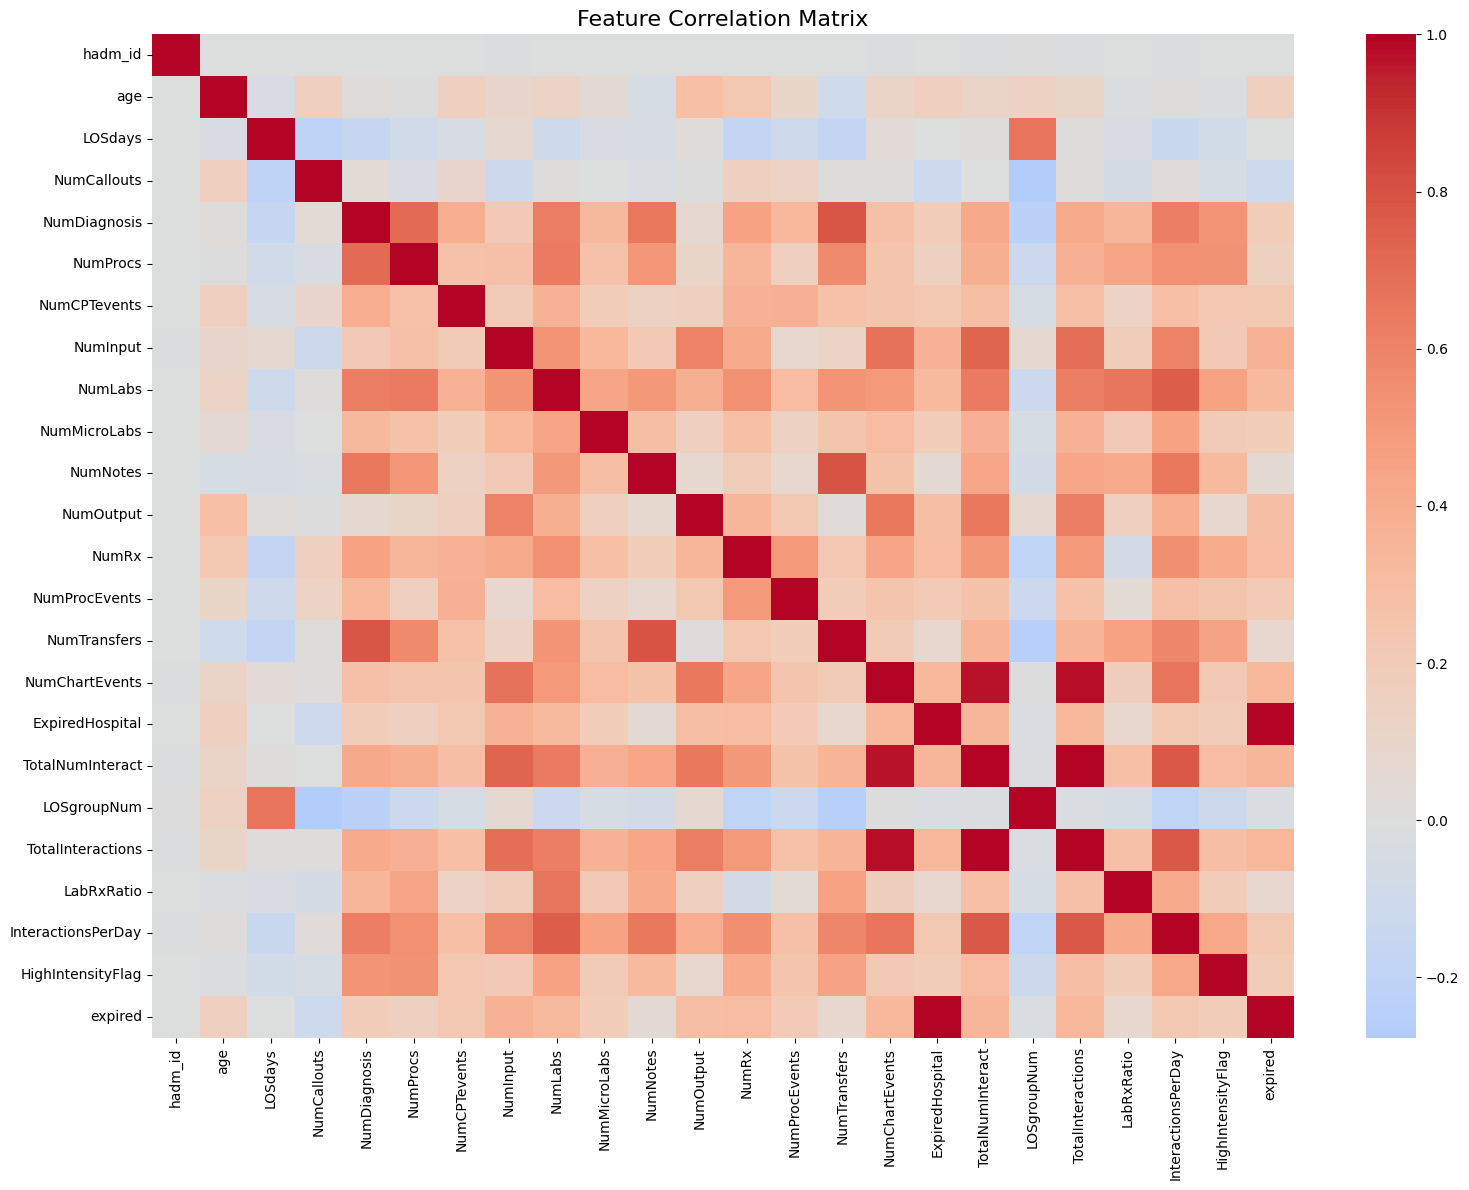


Applying feature elimination criteria:
1. High correlation with other features (>0.9)
2. Low variance (<0.01)
3. Missing values (>30%)
4. Domain irrelevance


ValueError: could not convert string to float: 'F'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.feature_selection import SelectKBest, f_classif
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)
df['expired'] = df['ExpiredHospital'].astype(int)

# --------------------------
# 2. Correlation & Heatmap Analysis
# --------------------------
print("\nCalculating correlations and generating heatmap...")
plt.figure(figsize=(16, 12))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

# --------------------------
# 3. Feature Elimination Criteria
# --------------------------
print("\nApplying feature elimination criteria:")
print("1. High correlation with other features (>0.9)")
print("2. Low variance (<0.01)")
print("3. Missing values (>30%)")
print("4. Domain irrelevance")

# Identify highly correlated features
corr_threshold = 0.9
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"\nHighly correlated features to drop: {to_drop}")

# Identify low variance features
numeric_cols = df.select_dtypes(include=np.number).columns
variance = df[numeric_cols].var()
low_variance = variance[variance < 0.01].index.tolist()
print(f"Low variance features to drop: {low_variance}")

# Identify features with high missingness
missing = df.isnull().mean()
high_missing = missing[missing > 0.3].index.tolist()
print(f"High missingness features to drop: {high_missing}")

# Domain-based removal
domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Domain-irrelevant features to drop: {domain_drop}")

# Combine all elimination criteria
all_to_drop = list(set(to_drop + low_variance + high_missing + domain_drop))
print(f"\nTotal features to remove: {len(all_to_drop)}")
print(all_to_drop)

# --------------------------
# 4. Feature Elimination Visualization
# --------------------------
plt.figure(figsize=(12, 6))
sns.barplot(x=corr_matrix['expired'].abs().sort_values(ascending=False).index,
            y=corr_matrix['expired'].abs().sort_values(ascending=False),
            palette='viridis')
plt.axhline(y=0.1, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Absolute Correlation with Mortality Target', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Absolute Correlation')
plt.legend()
plt.tight_layout()
plt.savefig('feature_correlation.png', dpi=300)
plt.show()

# --------------------------
# 5. Feature Transformation & Selection
# --------------------------
print("\nPerforming feature transformation and selection...")
df_clean = df.drop(columns=all_to_drop, errors='ignore')

# Handle missing values
for col in df_clean.select_dtypes(include=np.number).columns:
    df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Log transform skewed features
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

# Encode categorical variables
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion']
df_clean = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)

# --------------------------
# 6. Feature Distribution Visualization
# --------------------------
print("\nGenerating feature distribution visualizations...")
plt.figure(figsize=(16, 12))
df_clean[numeric_cols].hist(bins=30, layout=(6, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# --------------------------
# 7. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# 8. Model Selection & Stability Check
# --------------------------
print("\nTraining and evaluating models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Stability check function
def check_stability(model, X, y, n_runs=5):
    """Check model stability across different random states"""
    accuracies = []
    for seed in range(42, 42 + n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        accuracies.append(acc)
    return np.mean(accuracies), np.std(accuracies)

# Evaluate models
results = []
for name, model in models.items():
    mean_acc, std_acc = check_stability(model, X_scaled, y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc
    })
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Results comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy']])

# --------------------------
# 9. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}

rf_tuner = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
rf_tuner.fit(X_train, y_train)
best_rf = rf_tuner.best_estimator_
print(f"\nBest Random Forest params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

# Tune Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5]
}

gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)
gb_tuner.fit(X_train, y_train)
best_gb = gb_tuner.best_estimator_
print(f"\nBest Gradient Boosting params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

# --------------------------
# 10. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"\n{name} Final Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# --------------------------
# 11. Feature Importance Analysis
# --------------------------
print("\nGenerating feature importance plots...")

# Random Forest feature importance
rf_importances = best_rf.feature_importances_
sorted_idx = np.argsort(rf_importances)[-15:]

plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances[sorted_idx], y=X.columns[sorted_idx], palette='mako')
plt.title('Top 15 Features - Random Forest Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()

# Logistic Regression coefficients
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
coefs = pd.Series(log_reg.coef_[0], index=X.columns).abs().sort_values(ascending=False)[:15]

plt.figure(figsize=(10, 6))
sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
plt.title('Top 15 Features - Logistic Regression Coefficients')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.savefig('logreg_feature_importance.png', dpi=300)
plt.show()

print("\nAnalysis complete! All visualizations saved to disk.")

Loading data and initial preprocessing...

Performing initial data cleaning...
Dropping columns with >30% missing values: []
Dropping domain-irrelevant features: ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']

Missing value treatment:
Numerical columns: Imputing with median
Categorical columns: Imputing with mode

Applying feature elimination criteria:
1. Low variance (<0.01)
2. High correlation with other features (>0.9)
3. Low correlation with target (<0.05 absolute correlation)


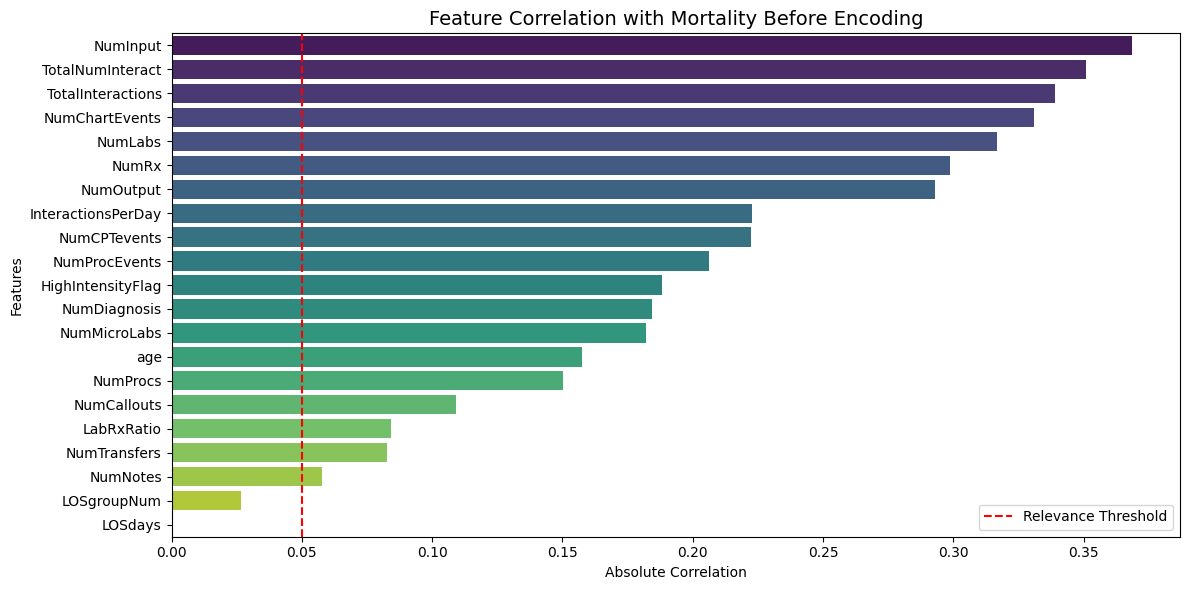


Encoding categorical variables...

Calculating correlations and generating heatmap...

Low variance features to drop: ['admit_location_HMO REFERRAL/SICK', 'admit_location_TRANSFER FROM OTHER HEALT', 'admit_location_TRANSFER FROM SKILLED NUR', 'admit_location_TRSF WITHIN THIS FACILITY', 'religion_BAPTIST', 'religion_BUDDHIST', 'religion_CHRISTIAN SCIENTIST', 'religion_GREEK ORTHODOX', 'religion_HEBREW', 'religion_HINDU', "religion_JEHOVAH'S WITNESS", 'religion_LUTHERAN', 'religion_METHODIST', 'religion_MUSLIM', 'religion_ROMANIAN EAST. ORTH', 'religion_UNITARIAN-UNIVERSALIST', 'marital_status_LIFE PARTNER', 'marital_status_SEPARATED', 'marital_status_UNKNOWN (DEFAULT)', 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - FILIPINO', 'ethnicity_ASIAN - JAPANESE', 'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - OTHER', 'ethnicity_ASIAN - THAI', 'ethnicity_ASIAN

<Figure size 2000x1600 with 0 Axes>

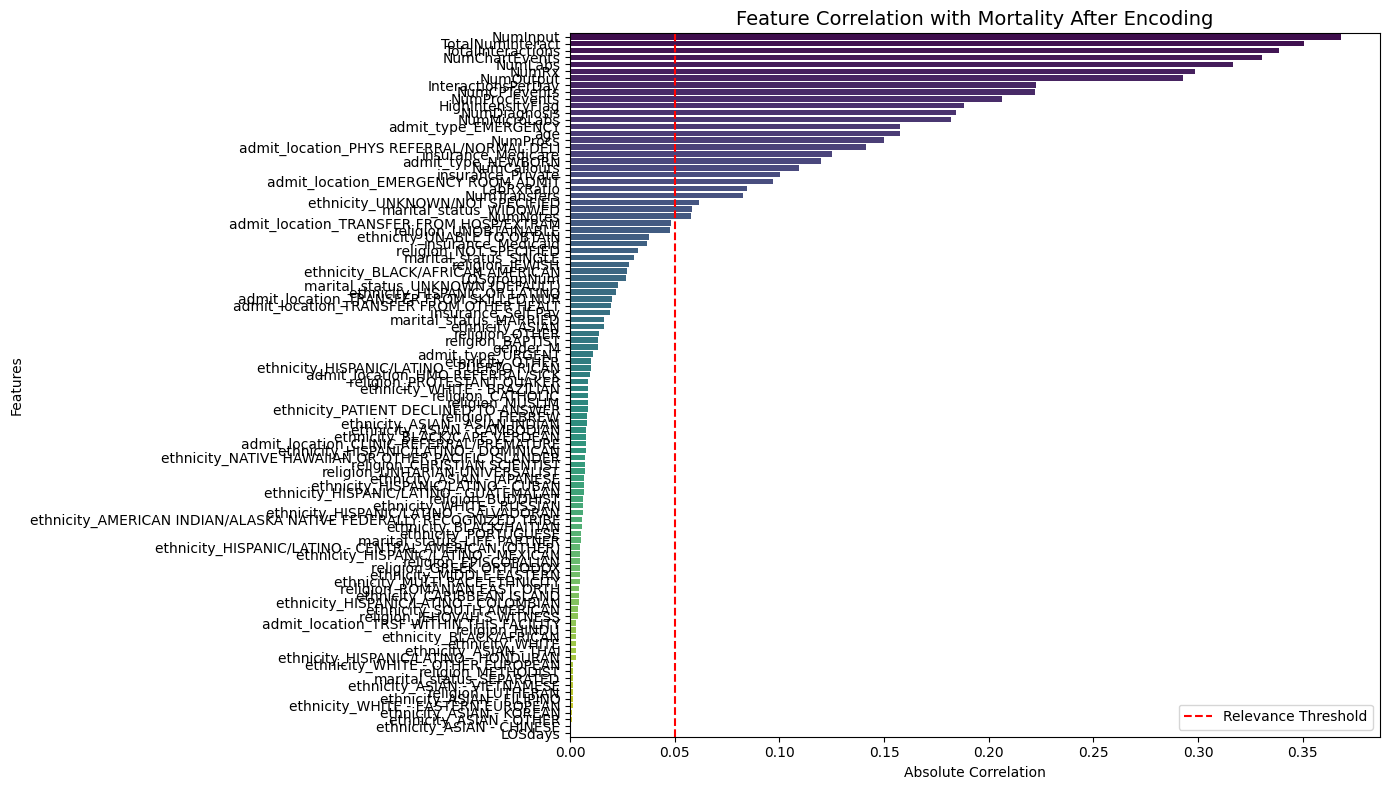


Dataset shape before cleaning: (58976, 103)
Dataset shape after cleaning: (58976, 26)

Performing feature transformation...
Skewed features to transform: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'LabRxRatio', 'InteractionsPerDay', 'HighIntensityFlag', 'expired']


<Figure size 1800x1400 with 0 Axes>

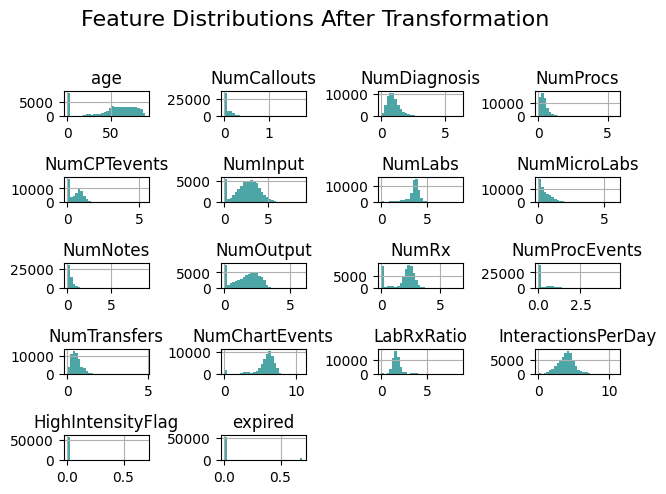

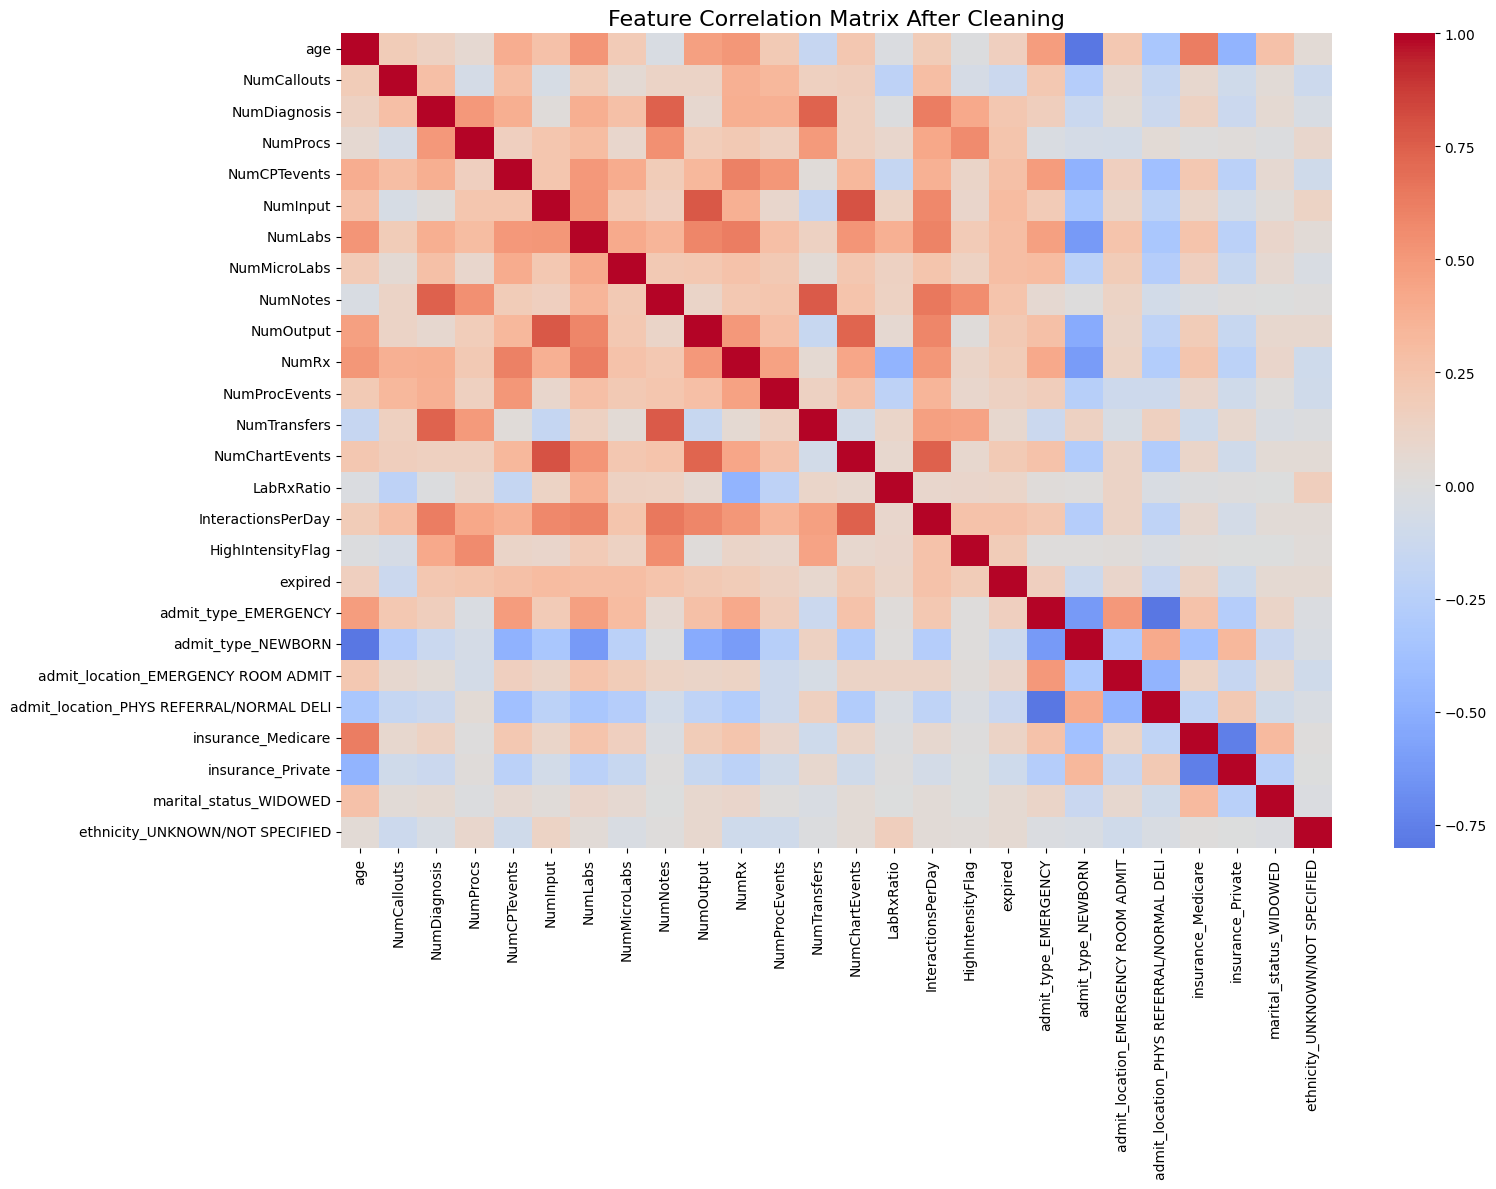


Training and evaluating models...


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)
df['expired'] = df['ExpiredHospital'].astype(int)

# --------------------------
# 2. Initial Data Cleaning
# --------------------------
print("\nPerforming initial data cleaning...")

# Drop columns with >30% missing values
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
print(f"Dropping columns with >30% missing values: {columns_to_drop}")
df.drop(columns=columns_to_drop, inplace=True)

# Domain-based removal
domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Dropping domain-irrelevant features: {domain_drop}")
df.drop(columns=domain_drop, inplace=True, errors='ignore')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

print("\nMissing value treatment:")
print(f"Numerical columns: Imputing with median")
print(f"Categorical columns: Imputing with mode")

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# 3. Feature Elimination Criteria & Visualization
# --------------------------
print("\nApplying feature elimination criteria:")
print("1. Low variance (<0.01)")
print("2. High correlation with other features (>0.9)")
print("3. Low correlation with target (<0.05 absolute correlation)")

# Visualize target correlation before encoding
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --------------------------
# 4. Correlation & Heatmap Analysis
# --------------------------
print("\nCalculating correlations and generating heatmap...")
plt.figure(figsize=(20, 16))
corr_matrix = df.corr()

# Feature elimination based on correlation
# 1. Low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]
print(f"\nLow variance features to drop: {low_variance_cols.tolist()}")

# 2. High correlation
corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"Highly correlated features to drop: {high_corr_cols}")

# 3. Low target correlation
target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()
print(f"Features with low target correlation: {low_target_corr_cols}")

# Combine all elimination criteria
all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
# Don't drop the target variable
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')
    
print(f"\nTotal features to remove: {len(all_to_drop)}")
print(all_to_drop)

# Visualize target correlation after encoding
plt.figure(figsize=(14, 8))
corr_with_target = corr_matrix['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality After Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('post_encoding_correlation.png', dpi=300)
plt.show()

# Create cleaned dataset
df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape before cleaning: {df.shape}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# --------------------------
# 5. Feature Transformation & Visualization
# --------------------------
print("\nPerforming feature transformation...")

# Log transform skewed features
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
print(f"Skewed features to transform: {skewed_cols.tolist()}")

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

# Feature Distribution Visualization
plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# Final correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Feature Correlation Matrix After Cleaning', fontsize=16)
plt.tight_layout()
plt.savefig('final_correlation_heatmap.png', dpi=300)
plt.show()

# --------------------------
# 6. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# 7. Model Selection & Stability Check
# --------------------------
print("\nTraining and evaluating models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Stability check function
def check_stability(model, X, y, n_runs=5):
    """Check model stability across different random states"""
    accuracies = []
    auc_scores = []
    for seed in range(42, 42 + n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, model.predict(X_test))
        auc_score = roc_auc_score(y_test, y_proba)
        accuracies.append(acc)
        auc_scores.append(auc_score)
    return np.mean(accuracies), np.std(accuracies), np.mean(auc_scores), np.std(auc_scores)

# Evaluate models
results = []
for name, model in models.items():
    mean_acc, std_acc, mean_auc, std_auc = check_stability(model, X_scaled, y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc,
        "Mean AUC": mean_auc,
        "Std AUC": std_auc
    })
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Results comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC']])

# --------------------------
# 8. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf_tuner = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
rf_tuner.fit(X_train, y_train)
best_rf = rf_tuner.best_estimator_
print(f"\nBest Random Forest params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

# Tune Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
gb_tuner.fit(X_train, y_train)
best_gb = gb_tuner.best_estimator_
print(f"\nBest Gradient Boosting params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

# Tune Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

lr_tuner = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
lr_tuner.fit(X_train, y_train)
best_lr = lr_tuner.best_estimator_
print(f"\nBest Logistic Regression params: {lr_tuner.best_params_}")
print(f"Best AUC: {lr_tuner.best_score_:.4f}")

# --------------------------
# 9. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"\n{name} Final Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# --------------------------
# 10. Feature Importance Analysis
# --------------------------
print("\nGenerating feature importance plots...")

# Random Forest feature importance
plt.figure(figsize=(12, 8))
rf_importances = best_rf.feature_importances_
sorted_idx = np.argsort(rf_importances)[-20:]
sns.barplot(x=rf_importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')
plt.title('Top 20 Features - Random Forest Importance', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()

# Gradient Boosting feature importance
plt.figure(figsize=(12, 8))
gb_importances = best_gb.feature_importances_
sorted_idx = np.argsort(gb_importances)[-20:]
sns.barplot(x=gb_importances[sorted_idx], y=X.columns[sorted_idx], palette='mako')
plt.title('Top 20 Features - Gradient Boosting Importance', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('gb_feature_importance.png', dpi=300)
plt.show()

# Logistic Regression coefficients
plt.figure(figsize=(12, 8))
coefs = pd.Series(best_lr.coef_[0], index=X.columns).abs().sort_values()[-20:]
sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
plt.title('Top 20 Features - Logistic Regression Coefficients', fontsize=14)
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.savefig('logreg_feature_importance.png', dpi=300)
plt.show()

print("\nAnalysis complete! All visualizations saved to disk.")

Loading data and initial preprocessing...

Performing initial data cleaning...


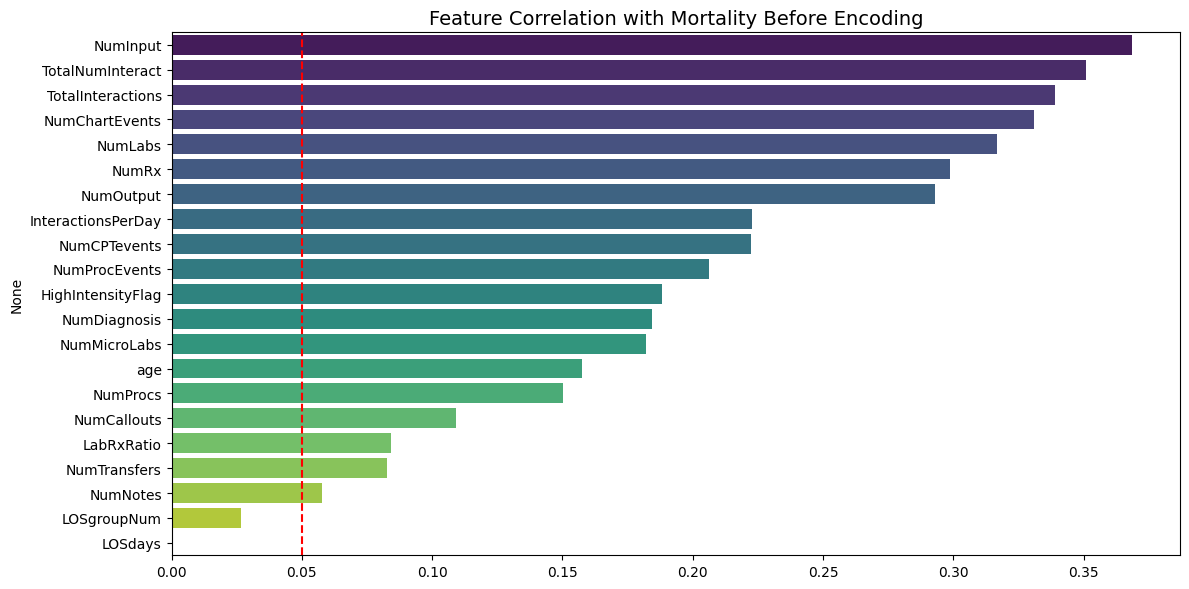


Dataset shape after cleaning: (58976, 26)


<Figure size 1800x1400 with 0 Axes>

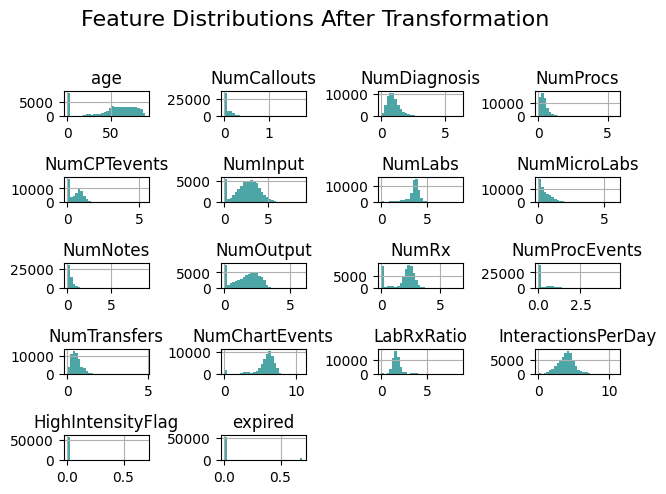

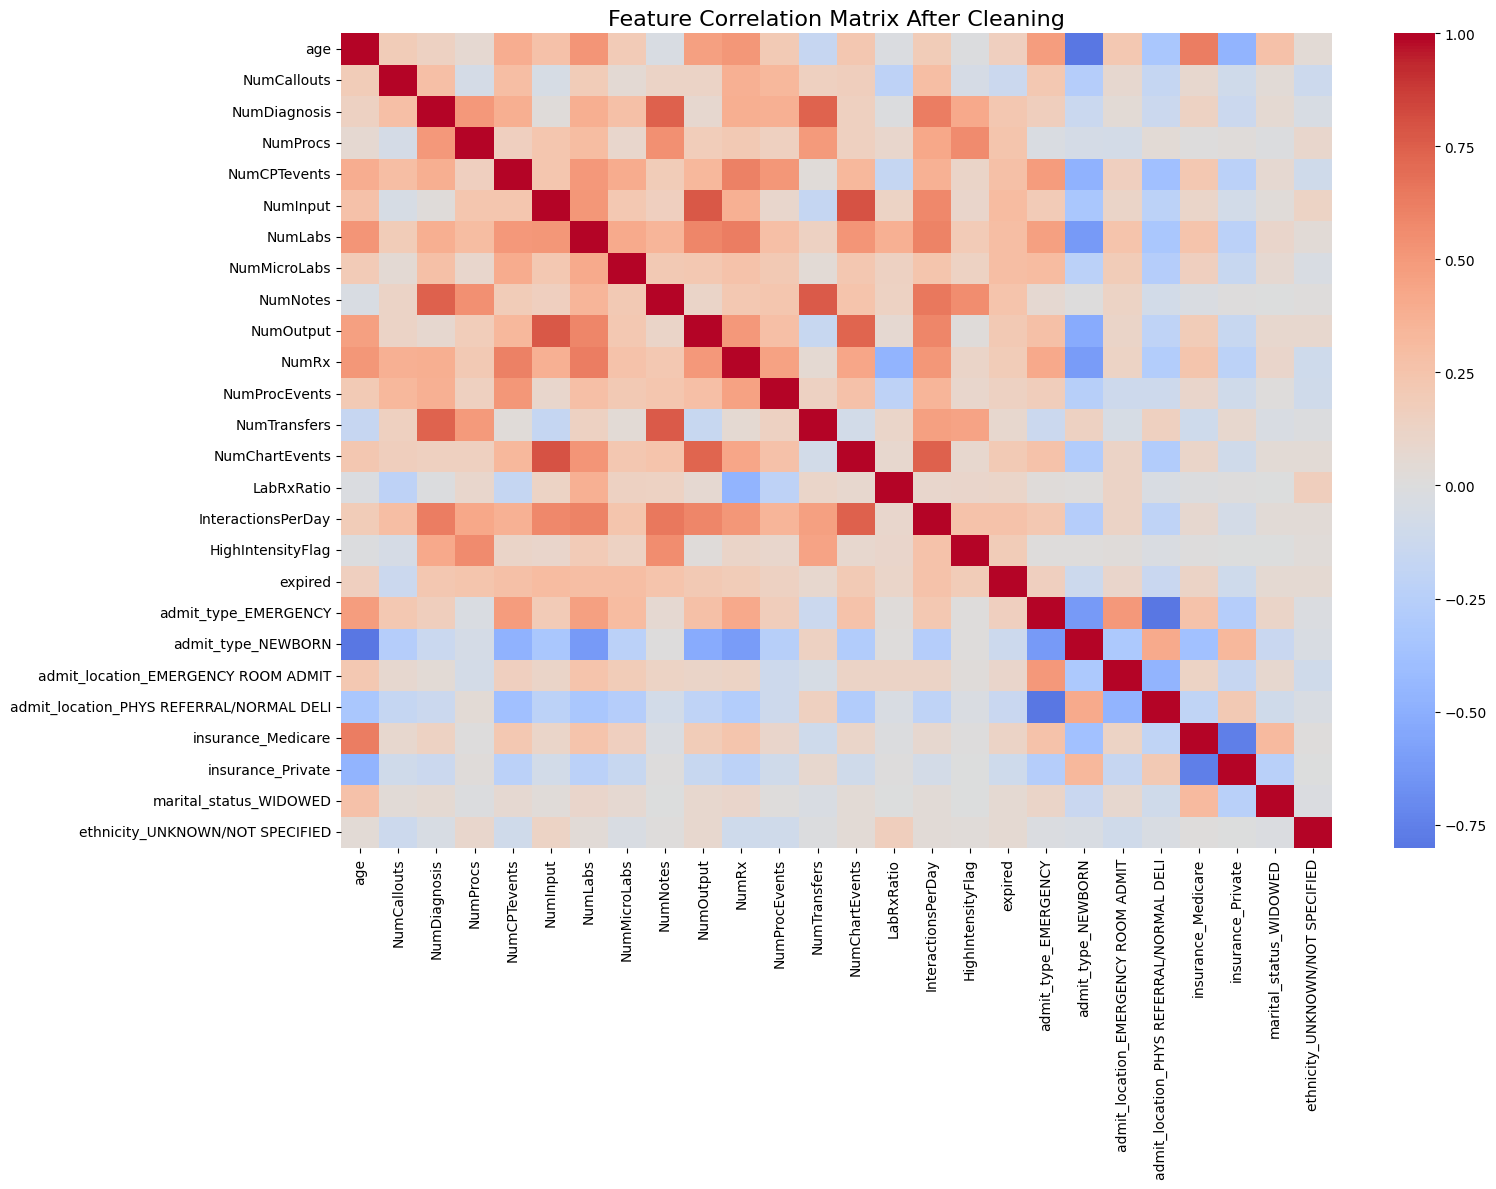


Training and evaluating models...


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, accuracy_score, precision_recall_curve, auc
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)
df['expired'] = df['ExpiredHospital'].astype(int)

# --------------------------
# 2. Initial Data Cleaning
# --------------------------
print("\nPerforming initial data cleaning...")
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
df.drop(columns=columns_to_drop, inplace=True)

domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
df.drop(columns=domain_drop, inplace=True, errors='ignore')

num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# 3. Feature Elimination Criteria & Visualization
# --------------------------
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --------------------------
# 4. Correlation & Heatmap Analysis
# --------------------------
corr_matrix = df.corr()

selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]

corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [col for col in upper.columns if any(upper[col] > corr_threshold)]

target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()

all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')

df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape after cleaning: {df_clean.shape}")

# --------------------------
# 5. Feature Transformation & Visualization
# --------------------------
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix After Cleaning', fontsize=16)
plt.tight_layout()
plt.savefig('final_correlation_heatmap.png', dpi=300)
plt.show()

# --------------------------
# 6. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired'].astype(int)  # <-- Fixed here

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# 7. Model Selection & Stability Check
# --------------------------
print("\nTraining and evaluating models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

def check_stability(model, X, y, n_runs=5):
    accuracies, auc_scores = [], []
    for seed in range(42, 42 + n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, model.predict(X_test))
        auc_score = roc_auc_score(y_test, y_proba)
        accuracies.append(acc)
        auc_scores.append(auc_score)
    return np.mean(accuracies), np.std(accuracies), np.mean(auc_scores), np.std(auc_scores)

results = []
for name, model in models.items():
    mean_acc, std_acc, mean_auc, std_auc = check_stability(model, X_scaled, y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc,
        "Mean AUC": mean_auc,
        "Std AUC": std_auc
    })
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC']])

# --------------------------
# 8. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}
rf_tuner = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
rf_tuner.fit(X_train, y_train)
best_rf = rf_tuner.best_estimator_
print(f"\nBest Random Forest params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
gb_tuner.fit(X_train, y_train)
best_gb = gb_tuner.best_estimator_
print(f"\nBest Gradient Boosting params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
lr_tuner = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
lr_tuner.fit(X_train, y_train)
best_lr = lr_tuner.best_estimator_
print(f"\nBest Logistic Regression params: {lr_tuner.best_params_}")
print(f"Best AUC: {lr_tuner.best_score_:.4f}")

# --------------------------
# 9. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print(f"\n{name} Final Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# --------------------------
# 10. Feature Importance
# --------------------------
print("\nGenerating feature importance plots...")

plt.figure(figsize=(12, 8))
rf_importances = best_rf.feature_importances_
sorted_idx = np.argsort(rf_importances)[-20:]
sns.barplot(x=rf_importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')
plt.title('Top 20 Features - Random Forest', fontsize=14)
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 8))
gb_importances = best_gb.feature_importances_
sorted_idx = np.argsort(gb_importances)[-20:]
sns.barplot(x=gb_importances[sorted_idx], y=X.columns[sorted_idx], palette='mako')
plt.title('Top 20 Features - Gradient Boosting', fontsize=14)
plt.tight_layout()
plt.savefig('gb_feature_importance.png', dpi=300)
plt.show()

plt.figure(figsize=(12, 8))
coefs = pd.Series(best_lr.coef_[0], index=X.columns).abs().sort_values()[-20:]
sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
plt.title('Top 20 Features - Logistic Regression', fontsize=14)
plt.tight_layout()
plt.savefig('logreg_feature_importance.png', dpi=300)
plt.show()

print("\nAnalysis complete! All visualizations saved.")


Loading data and initial preprocessing...
Target distribution:
expired
0    53122
1     5854
Name: count, dtype: int64

Performing initial data cleaning...
Dropping columns with >30% missing values: []
Dropping domain-irrelevant features: ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']

Missing value treatment:
Numerical columns: Imputing with median
Categorical columns: Imputing with mode

Applying feature elimination criteria:
1. Low variance (<0.01)
2. High correlation with other features (>0.9)
3. Low correlation with target (<0.05 absolute correlation)


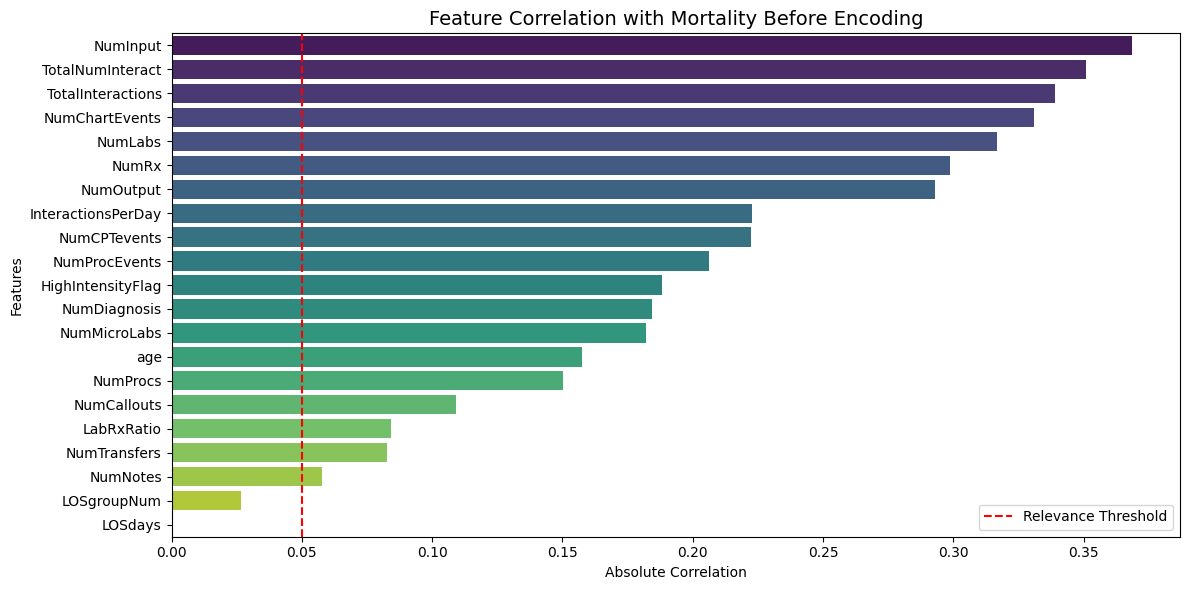


Encoding categorical variables...

Calculating correlations and generating heatmap...

Low variance features to drop: ['admit_location_HMO REFERRAL/SICK', 'admit_location_TRANSFER FROM OTHER HEALT', 'admit_location_TRANSFER FROM SKILLED NUR', 'admit_location_TRSF WITHIN THIS FACILITY', 'religion_BAPTIST', 'religion_BUDDHIST', 'religion_CHRISTIAN SCIENTIST', 'religion_GREEK ORTHODOX', 'religion_HEBREW', 'religion_HINDU', "religion_JEHOVAH'S WITNESS", 'religion_LUTHERAN', 'religion_METHODIST', 'religion_MUSLIM', 'religion_ROMANIAN EAST. ORTH', 'religion_UNITARIAN-UNIVERSALIST', 'marital_status_LIFE PARTNER', 'marital_status_SEPARATED', 'marital_status_UNKNOWN (DEFAULT)', 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - FILIPINO', 'ethnicity_ASIAN - JAPANESE', 'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - OTHER', 'ethnicity_ASIAN - THAI', 'ethnicity_ASIAN

<Figure size 2000x1600 with 0 Axes>

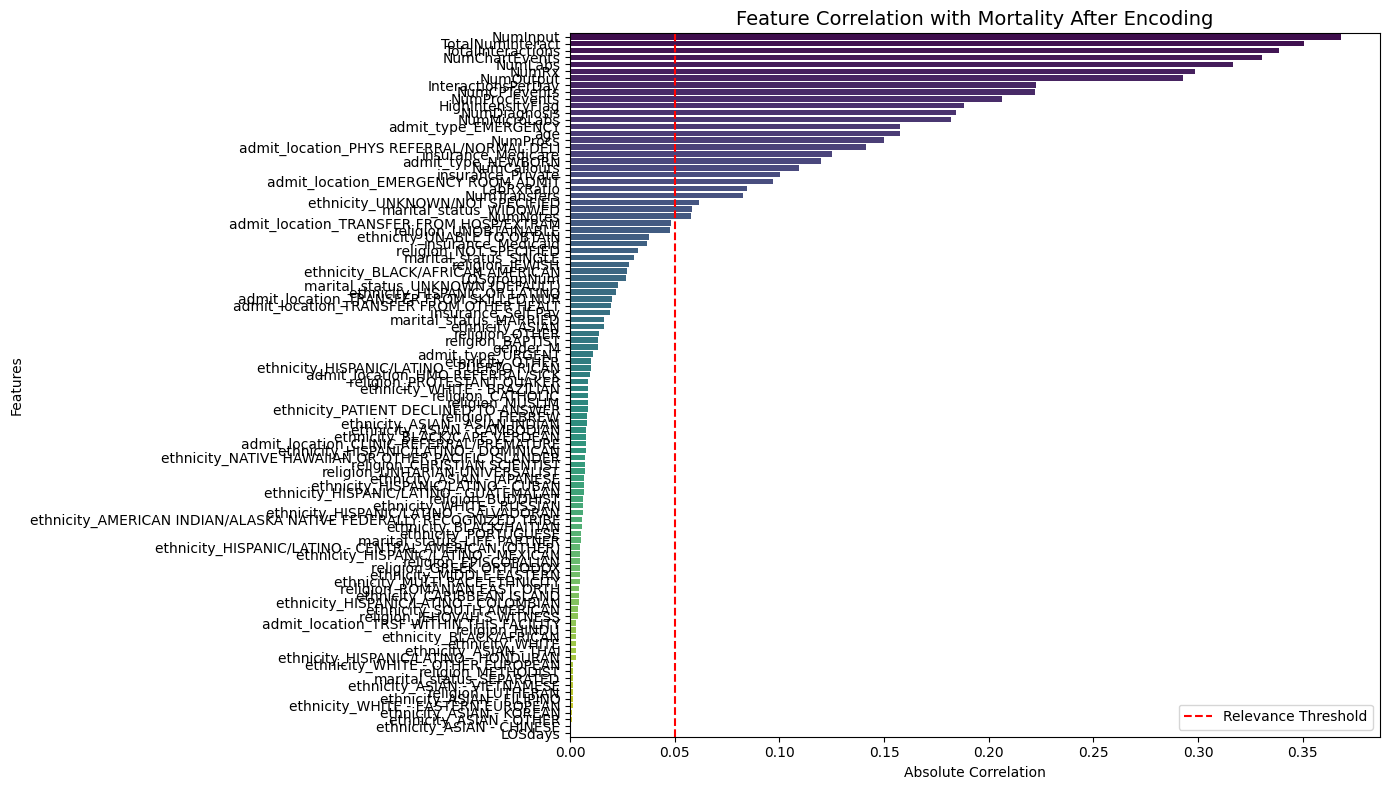


Dataset shape before cleaning: (58976, 103)
Dataset shape after cleaning: (58976, 26)

Performing feature transformation...
Skewed features to transform: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'LabRxRatio', 'InteractionsPerDay', 'HighIntensityFlag', 'expired']


<Figure size 1800x1400 with 0 Axes>

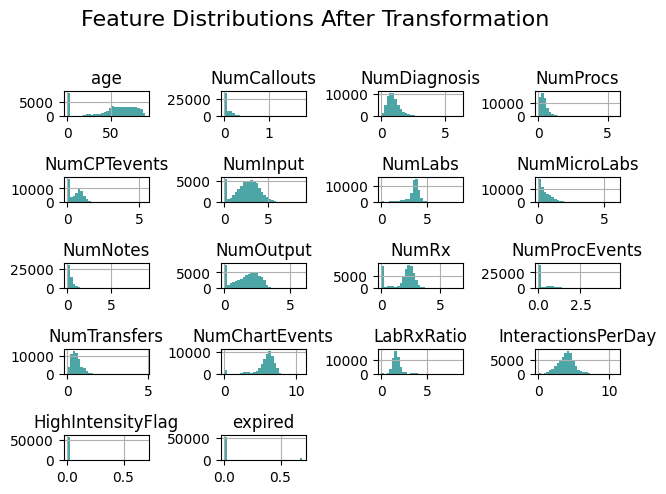

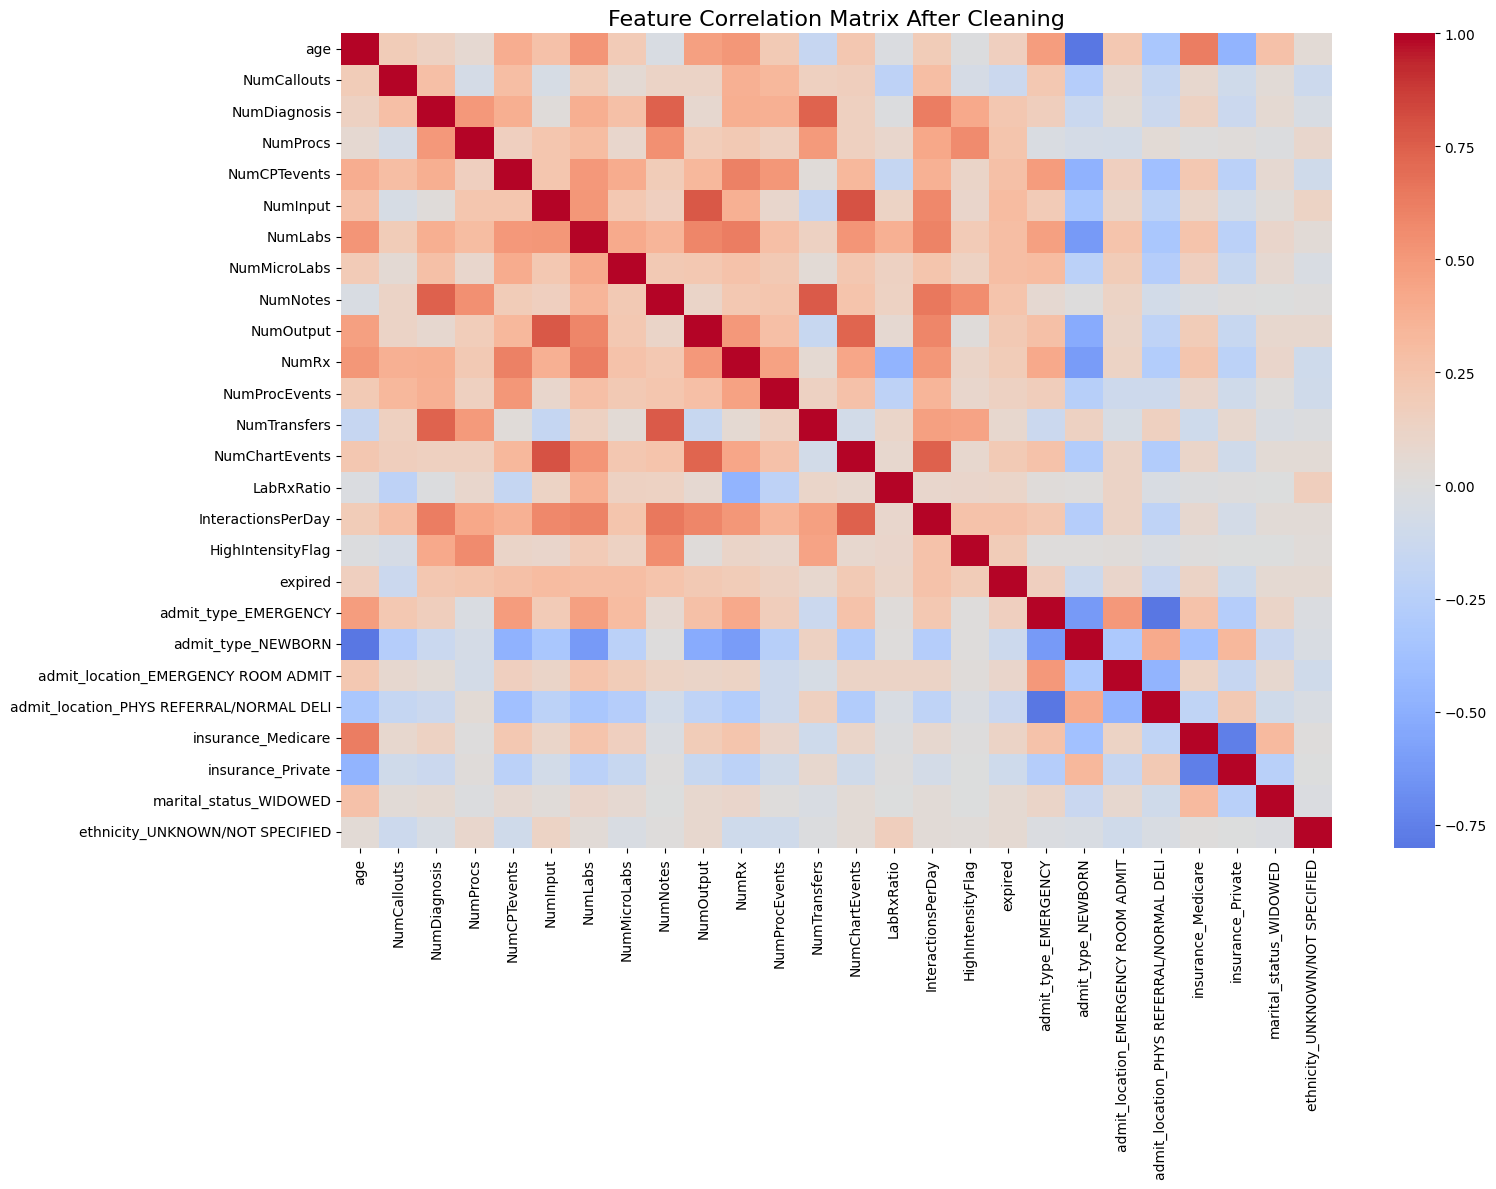


Target variable verification:
Unique values: [0]
Class distribution:
expired
0    58976
Name: count, dtype: int64

Training and evaluating models...

Training Logistic Regression...


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Ensure target is binary
df['expired'] = df['ExpiredHospital'].astype(int)
print(f"Target distribution:\n{df['expired'].value_counts()}")

# --------------------------
# 2. Initial Data Cleaning
# --------------------------
print("\nPerforming initial data cleaning...")

# Drop columns with >30% missing values
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
print(f"Dropping columns with >30% missing values: {columns_to_drop}")
df.drop(columns=columns_to_drop, inplace=True)

# Domain-based removal
domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Dropping domain-irrelevant features: {domain_drop}")
df.drop(columns=domain_drop, inplace=True, errors='ignore')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

print("\nMissing value treatment:")
print(f"Numerical columns: Imputing with median")
print(f"Categorical columns: Imputing with mode")

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# 3. Feature Elimination Criteria & Visualization
# --------------------------
print("\nApplying feature elimination criteria:")
print("1. Low variance (<0.01)")
print("2. High correlation with other features (>0.9)")
print("3. Low correlation with target (<0.05 absolute correlation)")

# Visualize target correlation before encoding
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --------------------------
# 4. Correlation & Heatmap Analysis
# --------------------------
print("\nCalculating correlations and generating heatmap...")
plt.figure(figsize=(20, 16))
corr_matrix = df.corr()

# Feature elimination based on correlation
# 1. Low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]
print(f"\nLow variance features to drop: {low_variance_cols.tolist()}")

# 2. High correlation
corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"Highly correlated features to drop: {high_corr_cols}")

# 3. Low target correlation
target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()
print(f"Features with low target correlation: {low_target_corr_cols}")

# Combine all elimination criteria
all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
# Don't drop the target variable
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')
    
print(f"\nTotal features to remove: {len(all_to_drop)}")
print(all_to_drop)

# Visualize target correlation after encoding
plt.figure(figsize=(14, 8))
corr_with_target = corr_matrix['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality After Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('post_encoding_correlation.png', dpi=300)
plt.show()

# Create cleaned dataset
df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape before cleaning: {df.shape}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# --------------------------
# 5. Feature Transformation & Visualization
# --------------------------
print("\nPerforming feature transformation...")

# Log transform skewed features
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
print(f"Skewed features to transform: {skewed_cols.tolist()}")

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

# Feature Distribution Visualization
plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# Final correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Feature Correlation Matrix After Cleaning', fontsize=16)
plt.tight_layout()
plt.savefig('final_correlation_heatmap.png', dpi=300)
plt.show()

# --------------------------
# 6. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired'].astype(int)  # Ensure target is integer type

# Verify target is binary
print("\nTarget variable verification:")
print(f"Unique values: {np.unique(y)}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# 7. Model Selection & Stability Check
# --------------------------
print("\nTraining and evaluating models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Stability check function
def check_stability(model, X, y, n_runs=5):
    """Check model stability across different random states"""
    accuracies = []
    auc_scores = []
    for seed in range(42, 42 + n_runs):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=seed
        )
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(y_test, model.predict(X_test))
        auc_score = roc_auc_score(y_test, y_proba)
        accuracies.append(acc)
        auc_scores.append(auc_score)
    return np.mean(accuracies), np.std(accuracies), np.mean(auc_scores), np.std(auc_scores)

# Evaluate models
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    mean_acc, std_acc, mean_auc, std_auc = check_stability(model, X_scaled, y)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc,
        "Mean AUC": mean_auc,
        "Std AUC": std_auc
    })
    
    print(f"{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Results comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC']])

# --------------------------
# 8. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print("\nTuning Random Forest...")
rf_tuner = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
rf_tuner.fit(X_train, y_train)
best_rf = rf_tuner.best_estimator_
print(f"Best Random Forest params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

# Tune Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

print("\nTuning Gradient Boosting...")
gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
gb_tuner.fit(X_train, y_train)
best_gb = gb_tuner.best_estimator_
print(f"Best Gradient Boosting params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

# Tune Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("\nTuning Logistic Regression...")
lr_tuner = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)
lr_tuner.fit(X_train, y_train)
best_lr = lr_tuner.best_estimator_
print(f"Best Logistic Regression params: {lr_tuner.best_params_}")
print(f"Best AUC: {lr_tuner.best_score_:.4f}")

# --------------------------
# 9. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"\n{name} Final Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# --------------------------
# 10. Feature Importance Analysis
# --------------------------
print("\nGenerating feature importance plots...")

# Random Forest feature importance
plt.figure(figsize=(12, 8))
rf_importances = best_rf.feature_importances_
sorted_idx = np.argsort(rf_importances)[-20:]
sns.barplot(x=rf_importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')
plt.title('Top 20 Features - Random Forest Importance', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('rf_feature_importance.png', dpi=300)
plt.show()

# Gradient Boosting feature importance
plt.figure(figsize=(12, 8))
gb_importances = best_gb.feature_importances_
sorted_idx = np.argsort(gb_importances)[-20:]
sns.barplot(x=gb_importances[sorted_idx], y=X.columns[sorted_idx], palette='mako')
plt.title('Top 20 Features - Gradient Boosting Importance', fontsize=14)
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('gb_feature_importance.png', dpi=300)
plt.show()

# Logistic Regression coefficients
plt.figure(figsize=(12, 8))
coefs = pd.Series(best_lr.coef_[0], index=X.columns).abs().sort_values()[-20:]
sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
plt.title('Top 20 Features - Logistic Regression Coefficients', fontsize=14)
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.savefig('logreg_feature_importance.png', dpi=300)
plt.show()

print("\nAnalysis complete! All visualizations saved to disk.")

Loading data and initial preprocessing...
Target distribution:
expired
0    53122
1     5854
Name: count, dtype: int64

Performing initial data cleaning...
Dropping columns with >30% missing values: []
Dropping domain-irrelevant features: ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']

Missing value treatment:
Numerical columns: Imputing with median
Categorical columns: Imputing with mode

Applying feature elimination criteria:
1. Low variance (<0.01)
2. High correlation with other features (>0.9)
3. Low correlation with target (<0.05 absolute correlation)


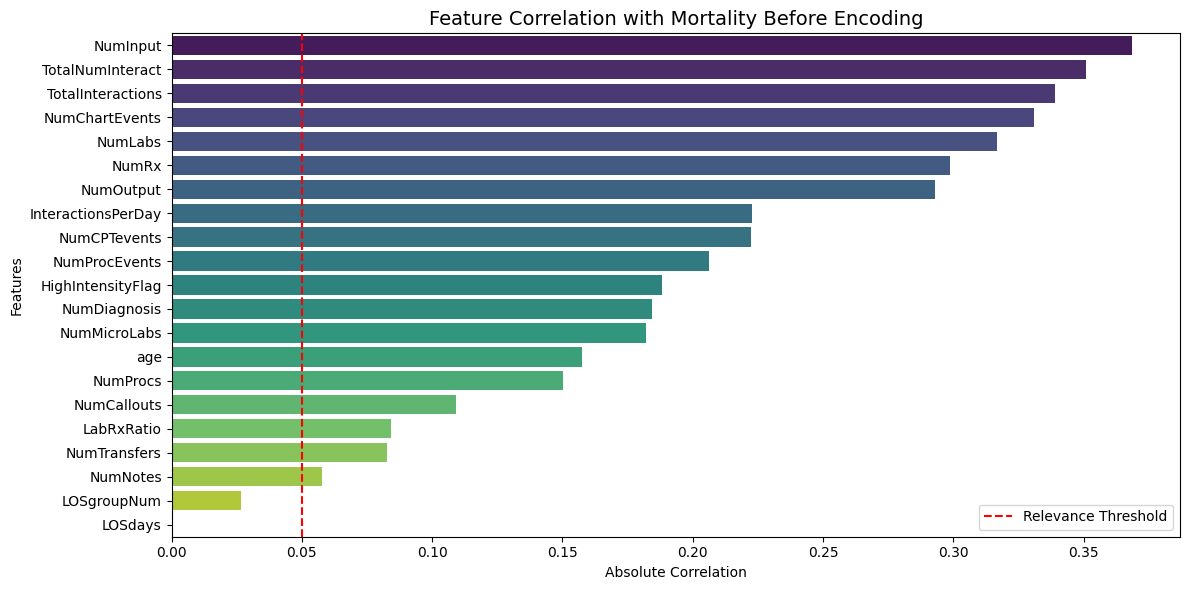


Encoding categorical variables...

Calculating correlations and generating heatmap...

Low variance features to drop: ['admit_location_HMO REFERRAL/SICK', 'admit_location_TRANSFER FROM OTHER HEALT', 'admit_location_TRANSFER FROM SKILLED NUR', 'admit_location_TRSF WITHIN THIS FACILITY', 'religion_BAPTIST', 'religion_BUDDHIST', 'religion_CHRISTIAN SCIENTIST', 'religion_GREEK ORTHODOX', 'religion_HEBREW', 'religion_HINDU', "religion_JEHOVAH'S WITNESS", 'religion_LUTHERAN', 'religion_METHODIST', 'religion_MUSLIM', 'religion_ROMANIAN EAST. ORTH', 'religion_UNITARIAN-UNIVERSALIST', 'marital_status_LIFE PARTNER', 'marital_status_SEPARATED', 'marital_status_UNKNOWN (DEFAULT)', 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - FILIPINO', 'ethnicity_ASIAN - JAPANESE', 'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - OTHER', 'ethnicity_ASIAN - THAI', 'ethnicity_ASIAN

<Figure size 2000x1600 with 0 Axes>

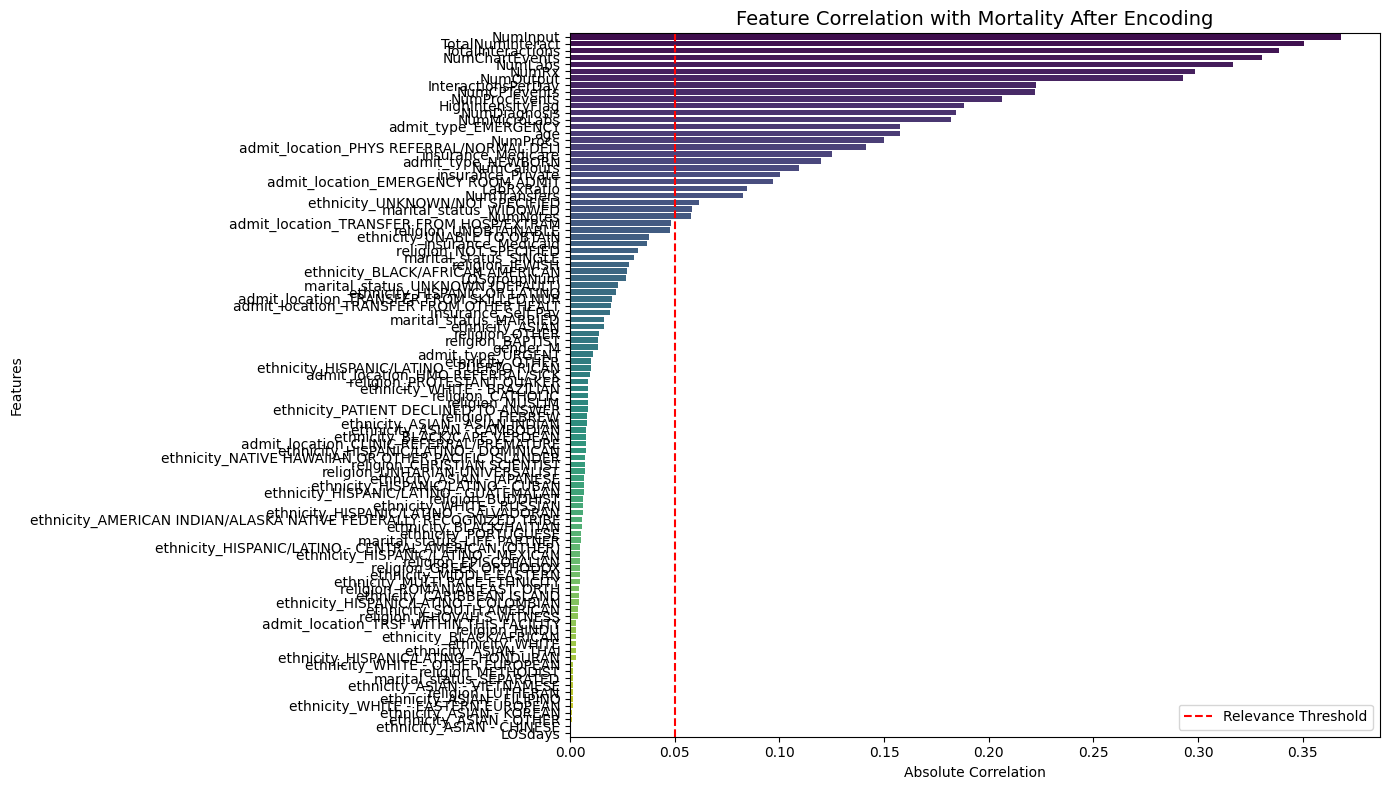


Dataset shape before cleaning: (58976, 103)
Dataset shape after cleaning: (58976, 26)

Performing feature transformation...
Skewed features to transform: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'LabRxRatio', 'InteractionsPerDay', 'HighIntensityFlag', 'expired']


<Figure size 1800x1400 with 0 Axes>

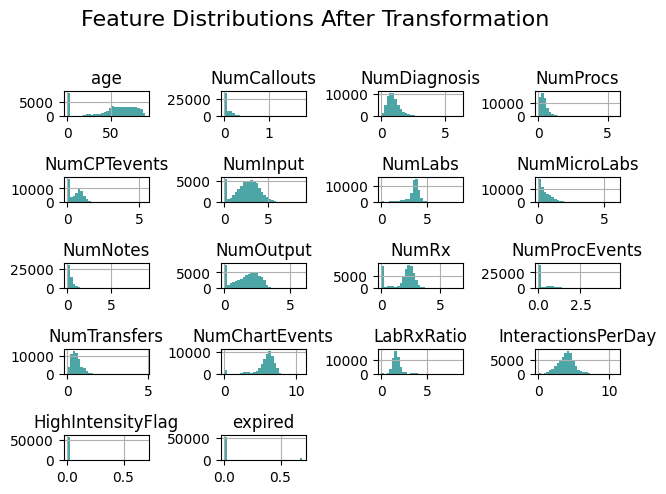

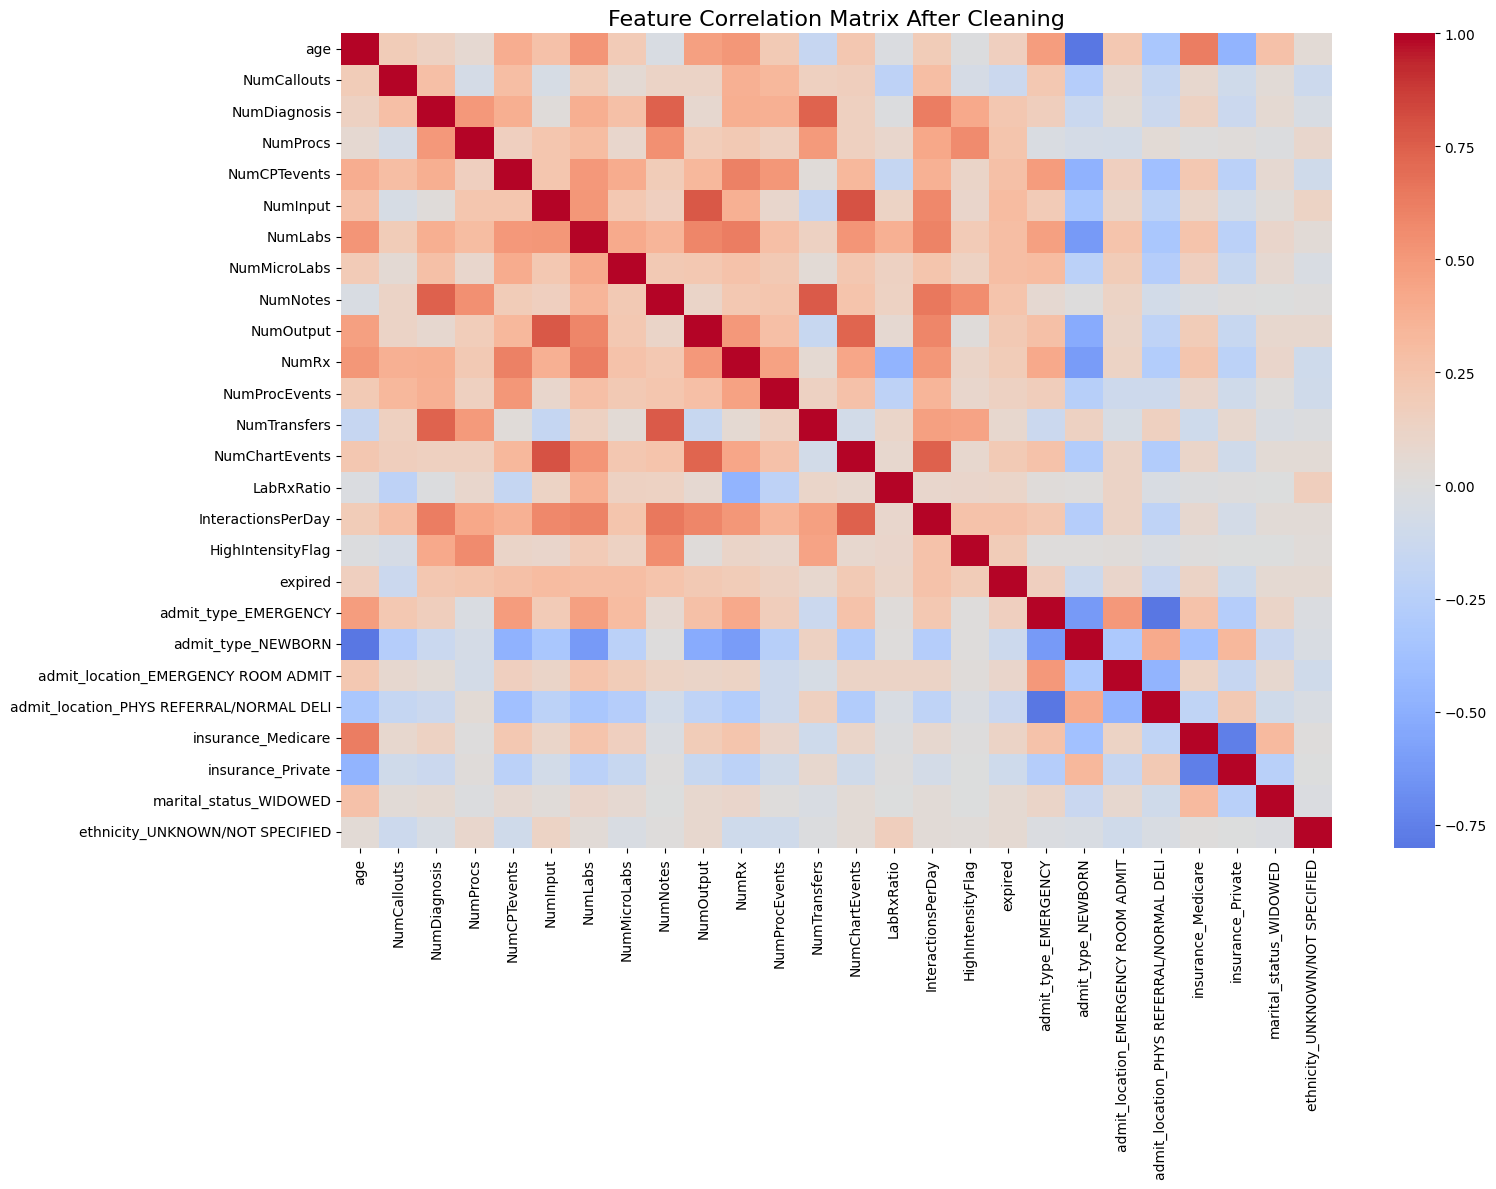


Target variable verification:
Unique values: [0]
Class distribution:
expired
0    58976
Name: count, dtype: int64

Training and evaluating models...

Training Logistic Regression...
Skipping seed 42 - only one class in training data
Skipping seed 43 - only one class in training data
Skipping seed 44 - only one class in training data
Skipping seed 45 - only one class in training data
Skipping seed 46 - only one class in training data
Skipping seed 47 - only one class in training data
Skipping seed 48 - only one class in training data
Skipping seed 49 - only one class in training data
Skipping seed 50 - only one class in training data
Skipping seed 51 - only one class in training data
Skipping seed 52 - only one class in training data
Skipping seed 53 - only one class in training data
Skipping seed 54 - only one class in training data
Skipping seed 55 - only one class in training data
Skipping seed 56 - only one class in training data
Skipping seed 57 - only one class in training data
S

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Ensure target is binary
df['expired'] = df['ExpiredHospital'].astype(int)
print(f"Target distribution:\n{df['expired'].value_counts()}")

# --------------------------
# 2. Initial Data Cleaning
# --------------------------
print("\nPerforming initial data cleaning...")

# Drop columns with >30% missing values
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
print(f"Dropping columns with >30% missing values: {columns_to_drop}")
df.drop(columns=columns_to_drop, inplace=True)

# Domain-based removal
domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Dropping domain-irrelevant features: {domain_drop}")
df.drop(columns=domain_drop, inplace=True, errors='ignore')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

print("\nMissing value treatment:")
print(f"Numerical columns: Imputing with median")
print(f"Categorical columns: Imputing with mode")

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# 3. Feature Elimination Criteria & Visualization
# --------------------------
print("\nApplying feature elimination criteria:")
print("1. Low variance (<0.01)")
print("2. High correlation with other features (>0.9)")
print("3. Low correlation with target (<0.05 absolute correlation)")

# Visualize target correlation before encoding
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --------------------------
# 4. Correlation & Heatmap Analysis
# --------------------------
print("\nCalculating correlations and generating heatmap...")
plt.figure(figsize=(20, 16))
corr_matrix = df.corr()

# Feature elimination based on correlation
# 1. Low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]
print(f"\nLow variance features to drop: {low_variance_cols.tolist()}")

# 2. High correlation
corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"Highly correlated features to drop: {high_corr_cols}")

# 3. Low target correlation
target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()
print(f"Features with low target correlation: {low_target_corr_cols}")

# Combine all elimination criteria
all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
# Don't drop the target variable
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')
    
print(f"\nTotal features to remove: {len(all_to_drop)}")
print(all_to_drop)

# Visualize target correlation after encoding
plt.figure(figsize=(14, 8))
corr_with_target = corr_matrix['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality After Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('post_encoding_correlation.png', dpi=300)
plt.show()

# Create cleaned dataset
df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape before cleaning: {df.shape}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# --------------------------
# 5. Feature Transformation & Visualization
# --------------------------
print("\nPerforming feature transformation...")

# Log transform skewed features
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
print(f"Skewed features to transform: {skewed_cols.tolist()}")

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

# Feature Distribution Visualization
plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# Final correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Feature Correlation Matrix After Cleaning', fontsize=16)
plt.tight_layout()
plt.savefig('final_correlation_heatmap.png', dpi=300)
plt.show()

# --------------------------
# 6. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired'].astype(int)  # Ensure target is integer type

# Verify target is binary
print("\nTarget variable verification:")
print(f"Unique values: {np.unique(y)}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# --------------------------
# 7. Model Selection & Stability Check
# --------------------------
print("\nTraining and evaluating models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Enhanced stability check function with class balance verification
def check_stability(model, X, y, n_runs=5):
    """Check model stability across different random states"""
    accuracies = []
    auc_scores = []
    seeds_used = []
    seed = 42
    
    while len(accuracies) < n_runs and seed < 100:  # Limit to 100 seeds
        try:
            # Create stratified split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=seed
            )
            
            # Verify both classes are present
            if len(np.unique(y_train)) < 2:
                print(f"Skipping seed {seed} - only one class in training data")
                seed += 1
                continue
                
            # Train and evaluate model
            model.fit(X_train, y_train)
            
            # Check if model supports probability estimates
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
                auc_score = roc_auc_score(y_test, y_proba)
            else:
                y_pred = model.predict(X_test)
                auc_score = roc_auc_score(y_test, y_pred)
                
            acc = accuracy_score(y_test, model.predict(X_test))
            
            accuracies.append(acc)
            auc_scores.append(auc_score)
            seeds_used.append(seed)
            print(f"Seed {seed}: Accuracy = {acc:.4f}, AUC = {auc_score:.4f}")
            
        except Exception as e:
            print(f"Error with seed {seed}: {str(e)}")
        
        seed += 1
    
    if len(accuracies) == 0:
        return 0, 0, 0, 0
    
    return np.mean(accuracies), np.std(accuracies), np.mean(auc_scores), np.std(auc_scores)

# Evaluate models
results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    mean_acc, std_acc, mean_auc, std_auc = check_stability(model, X_scaled, y)
    
    # Train final model on our main split
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Get AUC score
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = roc_auc_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc_score,
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc,
        "Mean AUC": mean_auc,
        "Std AUC": std_auc
    })
    
    print(f"{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {auc_score:.4f}")

# Results comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC']])

# --------------------------
# 8. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print("\nTuning Random Forest...")
rf_tuner = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
rf_tuner.fit(X_train, y_train)
best_rf = rf_tuner.best_estimator_
print(f"Best Random Forest params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

# Tune Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

print("\nTuning Gradient Boosting...")
gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
gb_tuner.fit(X_train, y_train)
best_gb = gb_tuner.best_estimator_
print(f"Best Gradient Boosting params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

# Tune Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("\nTuning Logistic Regression...")
lr_tuner = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
lr_tuner.fit(X_train, y_train)
best_lr = lr_tuner.best_estimator_
print(f"Best Logistic Regression params: {lr_tuner.best_params_}")
print(f"Best AUC: {lr_tuner.best_score_:.4f}")

# --------------------------
# 9. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for name, model in final_models.items():
    model.fit(X_train, y_train)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"\n{name} Final Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# --------------------------
# 10. Feature Importance Analysis
# --------------------------
print("\nGenerating feature importance plots...")

# Random Forest feature importance
if hasattr(best_rf, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    rf_importances = best_rf.feature_importances_
    sorted_idx = np.argsort(rf_importances)[-20:]
    sns.barplot(x=rf_importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')
    plt.title('Top 20 Features - Random Forest Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png', dpi=300)
    plt.show()

# Gradient Boosting feature importance
if hasattr(best_gb, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    gb_importances = best_gb.feature_importances_
    sorted_idx = np.argsort(gb_importances)[-20:]
    sns.barplot(x=gb_importances[sorted_idx], y=X.columns[sorted_idx], palette='mako')
    plt.title('Top 20 Features - Gradient Boosting Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('gb_feature_importance.png', dpi=300)
    plt.show()

# Logistic Regression coefficients
if hasattr(best_lr, 'coef_'):
    plt.figure(figsize=(12, 8))
    coefs = pd.Series(best_lr.coef_[0], index=X.columns).abs().sort_values()[-20:]
    sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
    plt.title('Top 20 Features - Logistic Regression Coefficients', fontsize=14)
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.savefig('logreg_feature_importance.png', dpi=300)
    plt.show()

print("\nAnalysis complete! All visualizations saved to disk.")

Loading data and initial preprocessing...
Target distribution:
expired
0    53122
1     5854
Name: count, dtype: int64

Performing initial data cleaning...
Dropping columns with >30% missing values: []
Dropping domain-irrelevant features: ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']

Missing value treatment:
Numerical columns: Imputing with median
Categorical columns: Imputing with mode

Applying feature elimination criteria:


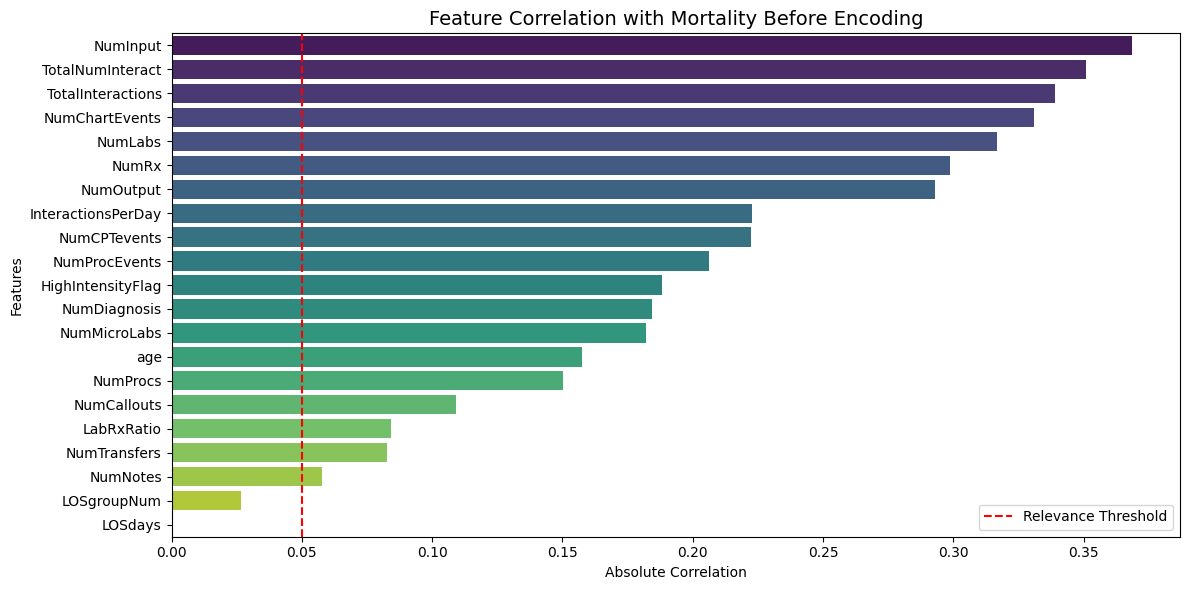


Encoding categorical variables...

Calculating correlations and generating heatmap...

Low variance features to drop: ['admit_location_HMO REFERRAL/SICK', 'admit_location_TRANSFER FROM OTHER HEALT', 'admit_location_TRANSFER FROM SKILLED NUR', 'admit_location_TRSF WITHIN THIS FACILITY', 'religion_BAPTIST', 'religion_BUDDHIST', 'religion_CHRISTIAN SCIENTIST', 'religion_GREEK ORTHODOX', 'religion_HEBREW', 'religion_HINDU', "religion_JEHOVAH'S WITNESS", 'religion_LUTHERAN', 'religion_METHODIST', 'religion_MUSLIM', 'religion_ROMANIAN EAST. ORTH', 'religion_UNITARIAN-UNIVERSALIST', 'marital_status_LIFE PARTNER', 'marital_status_SEPARATED', 'marital_status_UNKNOWN (DEFAULT)', 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - FILIPINO', 'ethnicity_ASIAN - JAPANESE', 'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - OTHER', 'ethnicity_ASIAN - THAI', 'ethnicity_ASIAN

<Figure size 2000x1600 with 0 Axes>

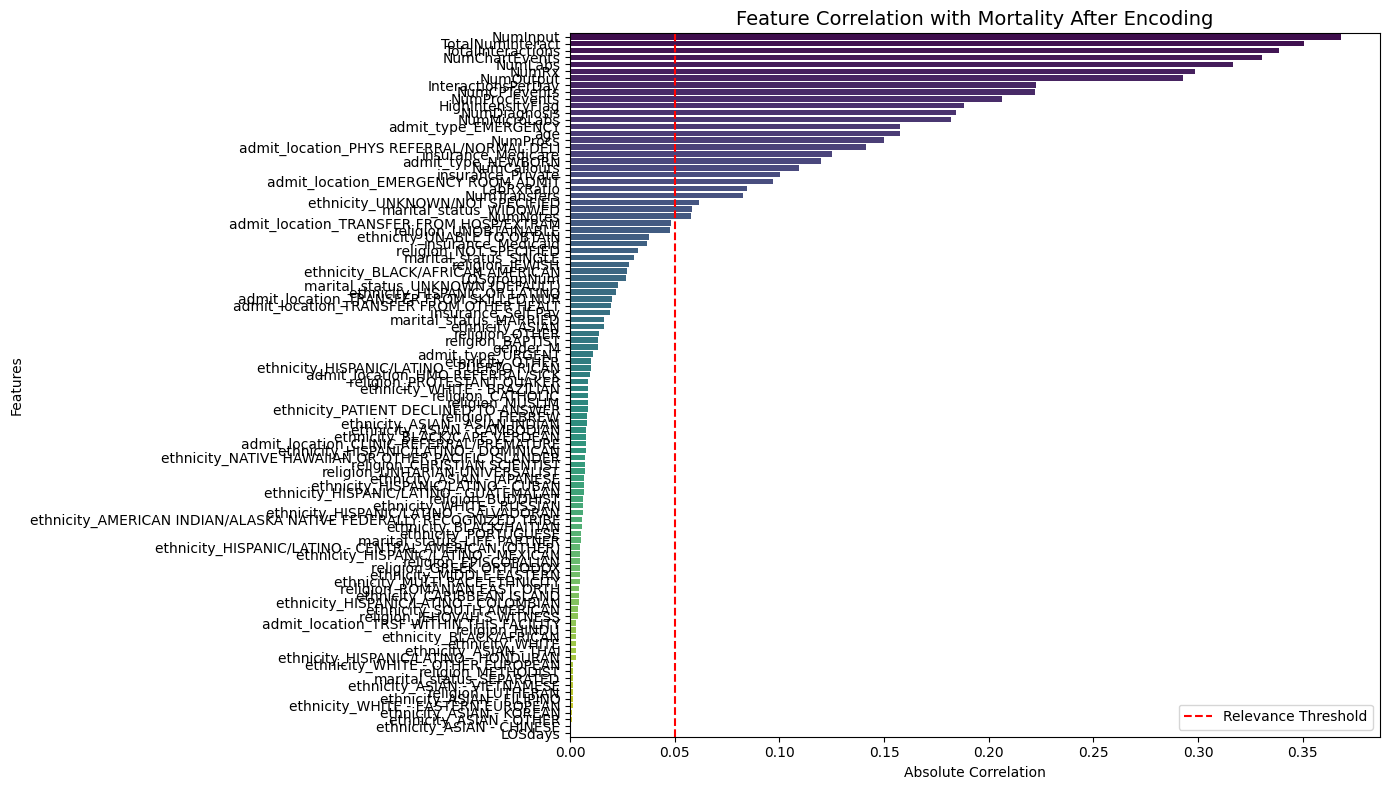


Dataset shape before cleaning: (58976, 103)
Dataset shape after cleaning: (58976, 26)

Performing feature transformation...
Skewed features to transform: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'LabRxRatio', 'InteractionsPerDay', 'HighIntensityFlag', 'expired']


<Figure size 1800x1400 with 0 Axes>

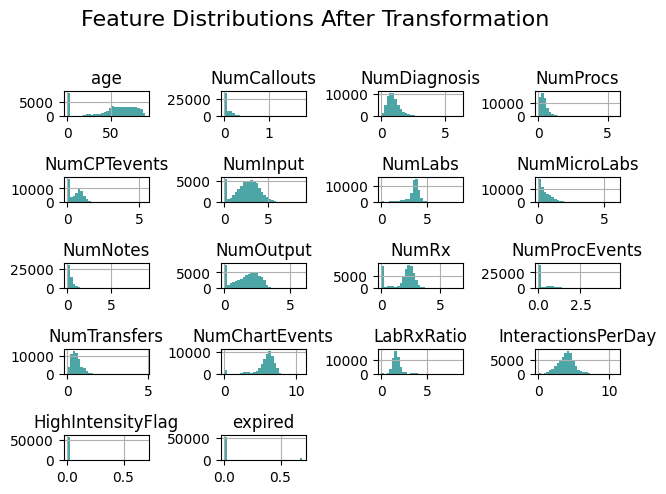

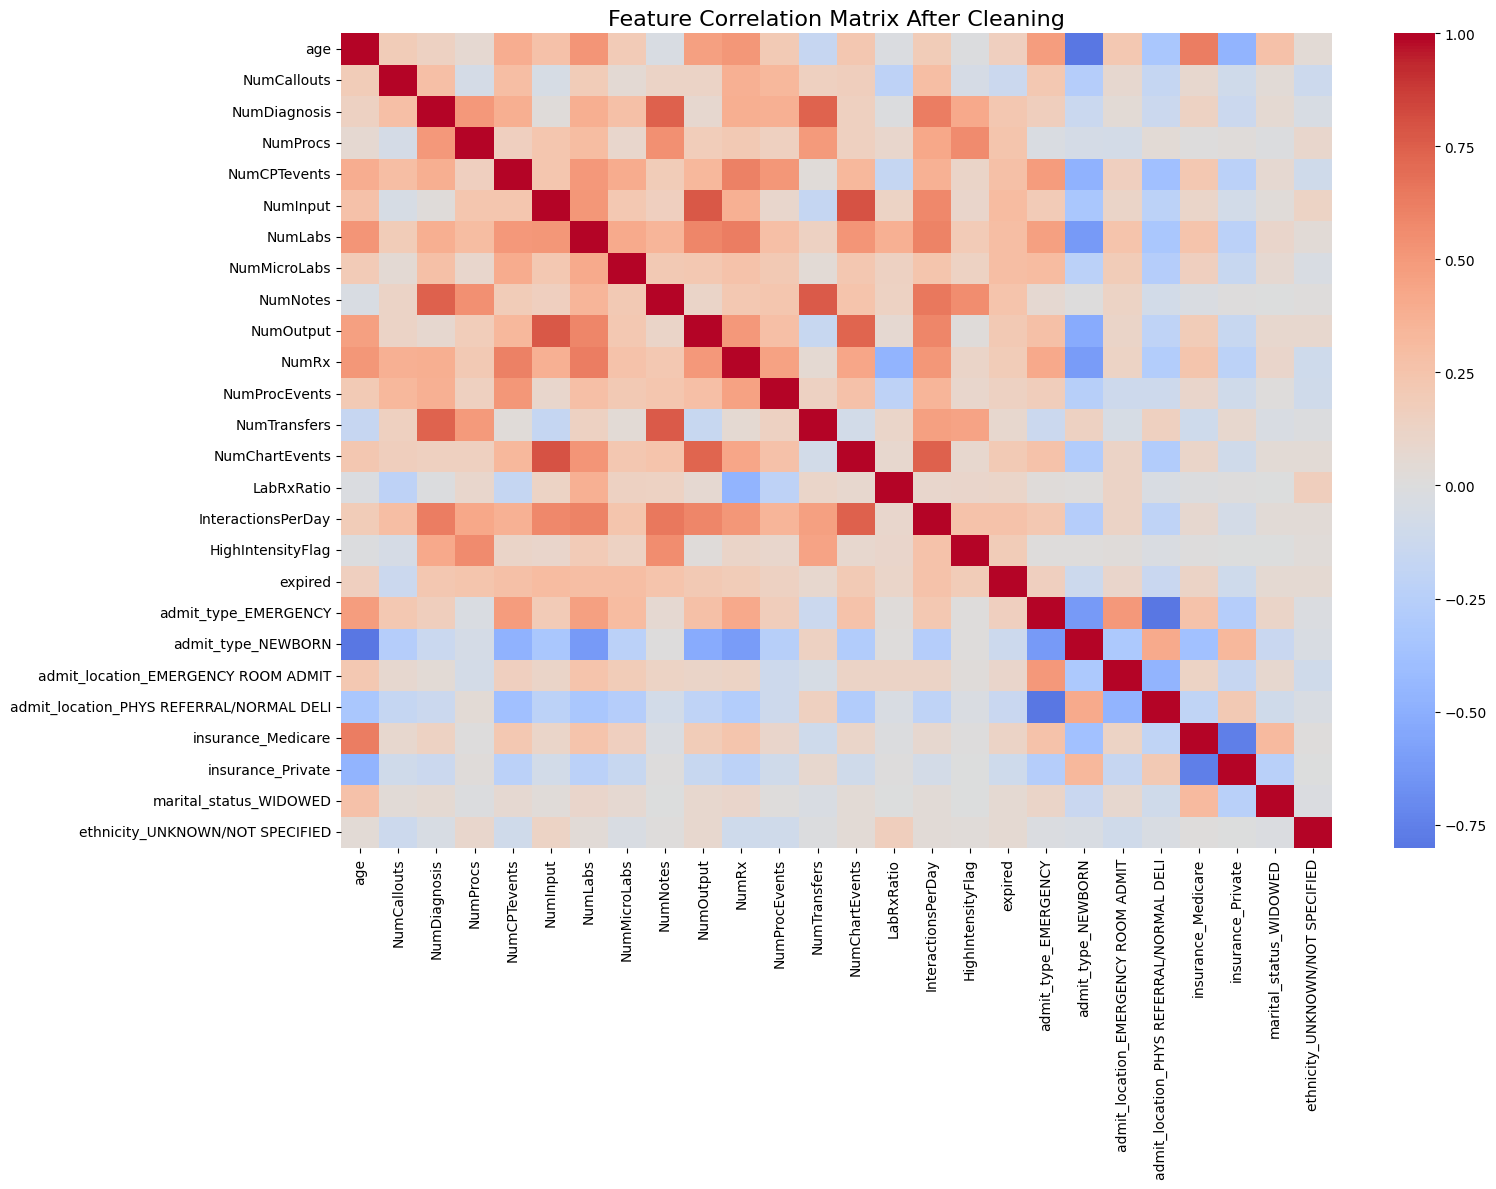


Target variable verification:
Unique values: [0]
Class distribution:
expired
0    58976
Name: count, dtype: int64

Applying SMOTE to balance training data...


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Ensure target is binary
df['expired'] = df['ExpiredHospital'].astype(int)
print(f"Target distribution:\n{df['expired'].value_counts()}")

print("\nPerforming initial data cleaning...")
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
print(f"Dropping columns with >30% missing values: {columns_to_drop}")
df.drop(columns=columns_to_drop, inplace=True)

domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Dropping domain-irrelevant features: {domain_drop}")
df.drop(columns=domain_drop, inplace=True, errors='ignore')

num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

print("\nMissing value treatment:")
print(f"Numerical columns: Imputing with median")
print(f"Categorical columns: Imputing with mode")

num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("\nApplying feature elimination criteria:")
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

print("\nEncoding categorical variables...")
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nCalculating correlations and generating heatmap...")
plt.figure(figsize=(20, 16))
corr_matrix = df.corr()

selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]
print(f"\nLow variance features to drop: {low_variance_cols.tolist()}")

corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"Highly correlated features to drop: {high_corr_cols}")

target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()
print(f"Features with low target correlation: {low_target_corr_cols}")

all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')

print(f"\nTotal features to remove: {len(all_to_drop)}")
print(all_to_drop)

plt.figure(figsize=(14, 8))
corr_with_target = corr_matrix['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality After Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('post_encoding_correlation.png', dpi=300)
plt.show()

df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape before cleaning: {df.shape}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

print("\nPerforming feature transformation...")
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
print(f"Skewed features to transform: {skewed_cols.tolist()}")

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Feature Correlation Matrix After Cleaning', fontsize=16)
plt.tight_layout()
plt.savefig('final_correlation_heatmap.png', dpi=300)
plt.show()

X = df_clean.drop(columns=['expired'])
y = df_clean['expired'].astype(int)

print("\nTarget variable verification:")
print(f"Unique values: {np.unique(y)}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print("\nApplying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Class distribution after SMOTE:\n{pd.Series(y_train_res).value_counts()}")

print("\nTraining and evaluating models...")
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

def check_stability(model, X, y, n_runs=5):
    accuracies, auc_scores, seeds_used = [], [], []
    seed = 42
    while len(accuracies) < n_runs and seed < 100:
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=seed
            )
            smote = SMOTE(random_state=seed)
            X_train, y_train = smote.fit_resample(X_train, y_train)

            if len(np.unique(y_train)) < 2:
                seed += 1
                continue

            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
            acc = accuracy_score(y_test, model.predict(X_test))
            auc_score = roc_auc_score(y_test, y_proba)
            accuracies.append(acc)
            auc_scores.append(auc_score)
            seeds_used.append(seed)
            print(f"Seed {seed}: Accuracy = {acc:.4f}, AUC = {auc_score:.4f}")
        except Exception as e:
            print(f"Error with seed {seed}: {str(e)}")
        seed += 1
    return np.mean(accuracies), np.std(accuracies), np.mean(auc_scores), np.std(auc_scores)

results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    mean_acc, std_acc, mean_auc, std_auc = check_stability(model, X_scaled, y)
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    auc_score = roc_auc_score(y_test, y_proba)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc_score,
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc,
        "Mean AUC": mean_auc,
        "Std AUC": std_auc
    })
    print(f"{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {auc_score:.4f}")

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC']])


Loading data and initial preprocessing...
Initial target distribution:
expired
0    53122
1     5854
Name: count, dtype: int64
Class ratio: 0.0993

Performing initial data cleaning...
Dropping columns with >30% missing values: []
Dropping domain-irrelevant features: ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']

Missing value treatment:
Numerical columns: Imputing with median
Categorical columns: Imputing with mode

Applying feature elimination criteria:
1. Low variance (<0.01)
2. High correlation with other features (>0.9)
3. Low correlation with target (<0.05 absolute correlation)


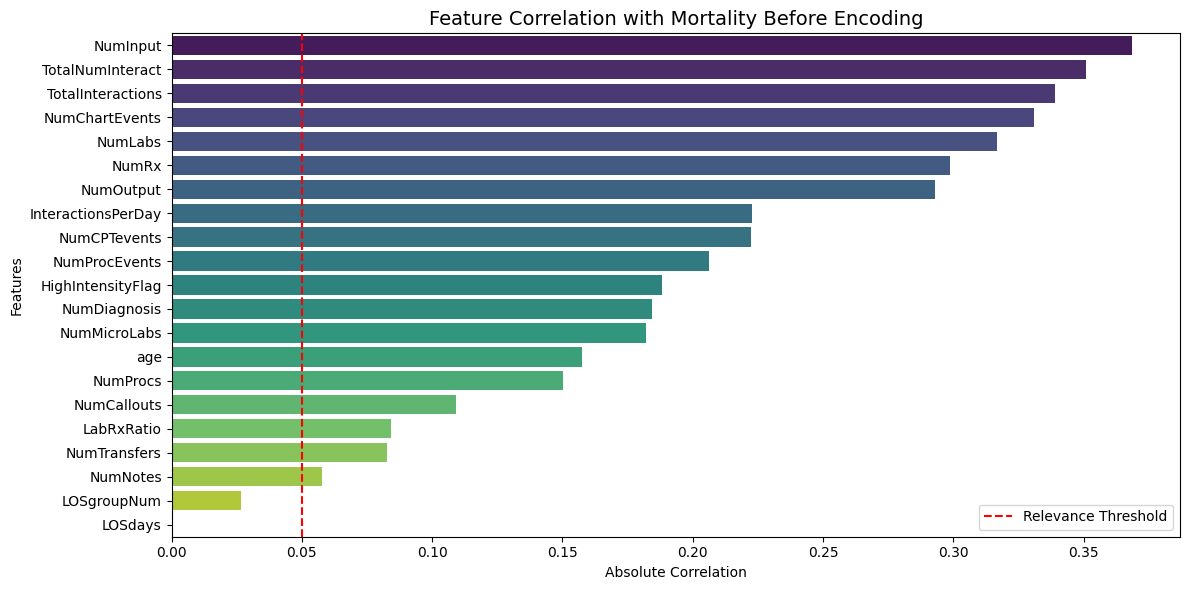


Encoding categorical variables...

Calculating correlations and generating heatmap...

Low variance features to drop: ['admit_location_HMO REFERRAL/SICK', 'admit_location_TRANSFER FROM OTHER HEALT', 'admit_location_TRANSFER FROM SKILLED NUR', 'admit_location_TRSF WITHIN THIS FACILITY', 'religion_BAPTIST', 'religion_BUDDHIST', 'religion_CHRISTIAN SCIENTIST', 'religion_GREEK ORTHODOX', 'religion_HEBREW', 'religion_HINDU', "religion_JEHOVAH'S WITNESS", 'religion_LUTHERAN', 'religion_METHODIST', 'religion_MUSLIM', 'religion_ROMANIAN EAST. ORTH', 'religion_UNITARIAN-UNIVERSALIST', 'marital_status_LIFE PARTNER', 'marital_status_SEPARATED', 'marital_status_UNKNOWN (DEFAULT)', 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - FILIPINO', 'ethnicity_ASIAN - JAPANESE', 'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - OTHER', 'ethnicity_ASIAN - THAI', 'ethnicity_ASIAN

<Figure size 2000x1600 with 0 Axes>

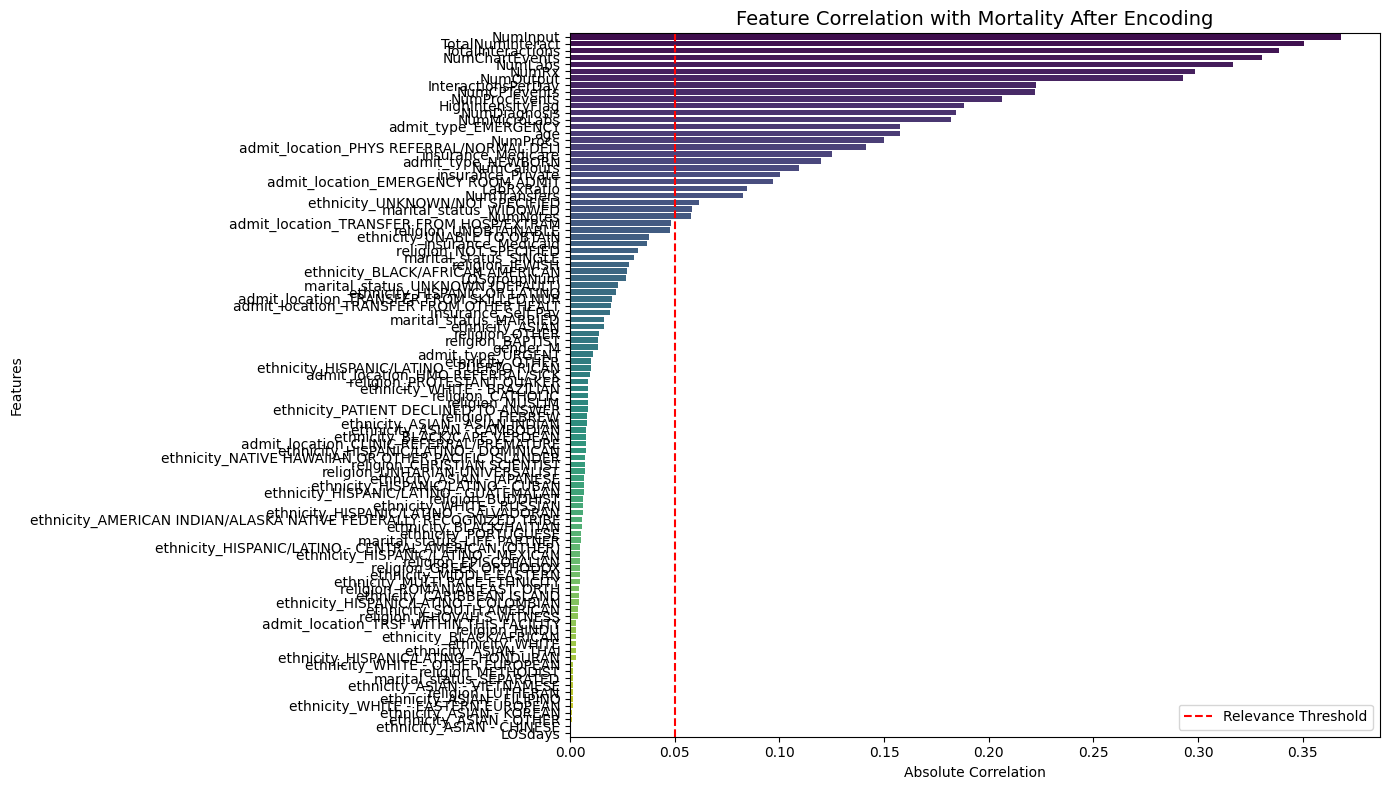


Dataset shape before cleaning: (58976, 103)
Dataset shape after cleaning: (58976, 26)

Performing feature transformation...
Skewed features to transform: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'LabRxRatio', 'InteractionsPerDay', 'HighIntensityFlag', 'expired']


<Figure size 1800x1400 with 0 Axes>

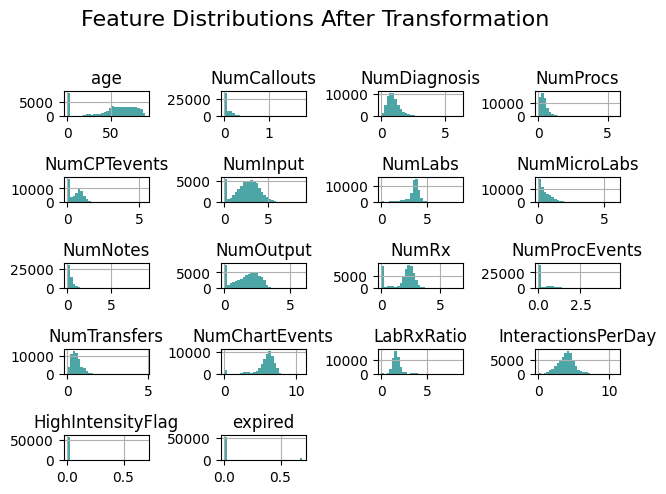

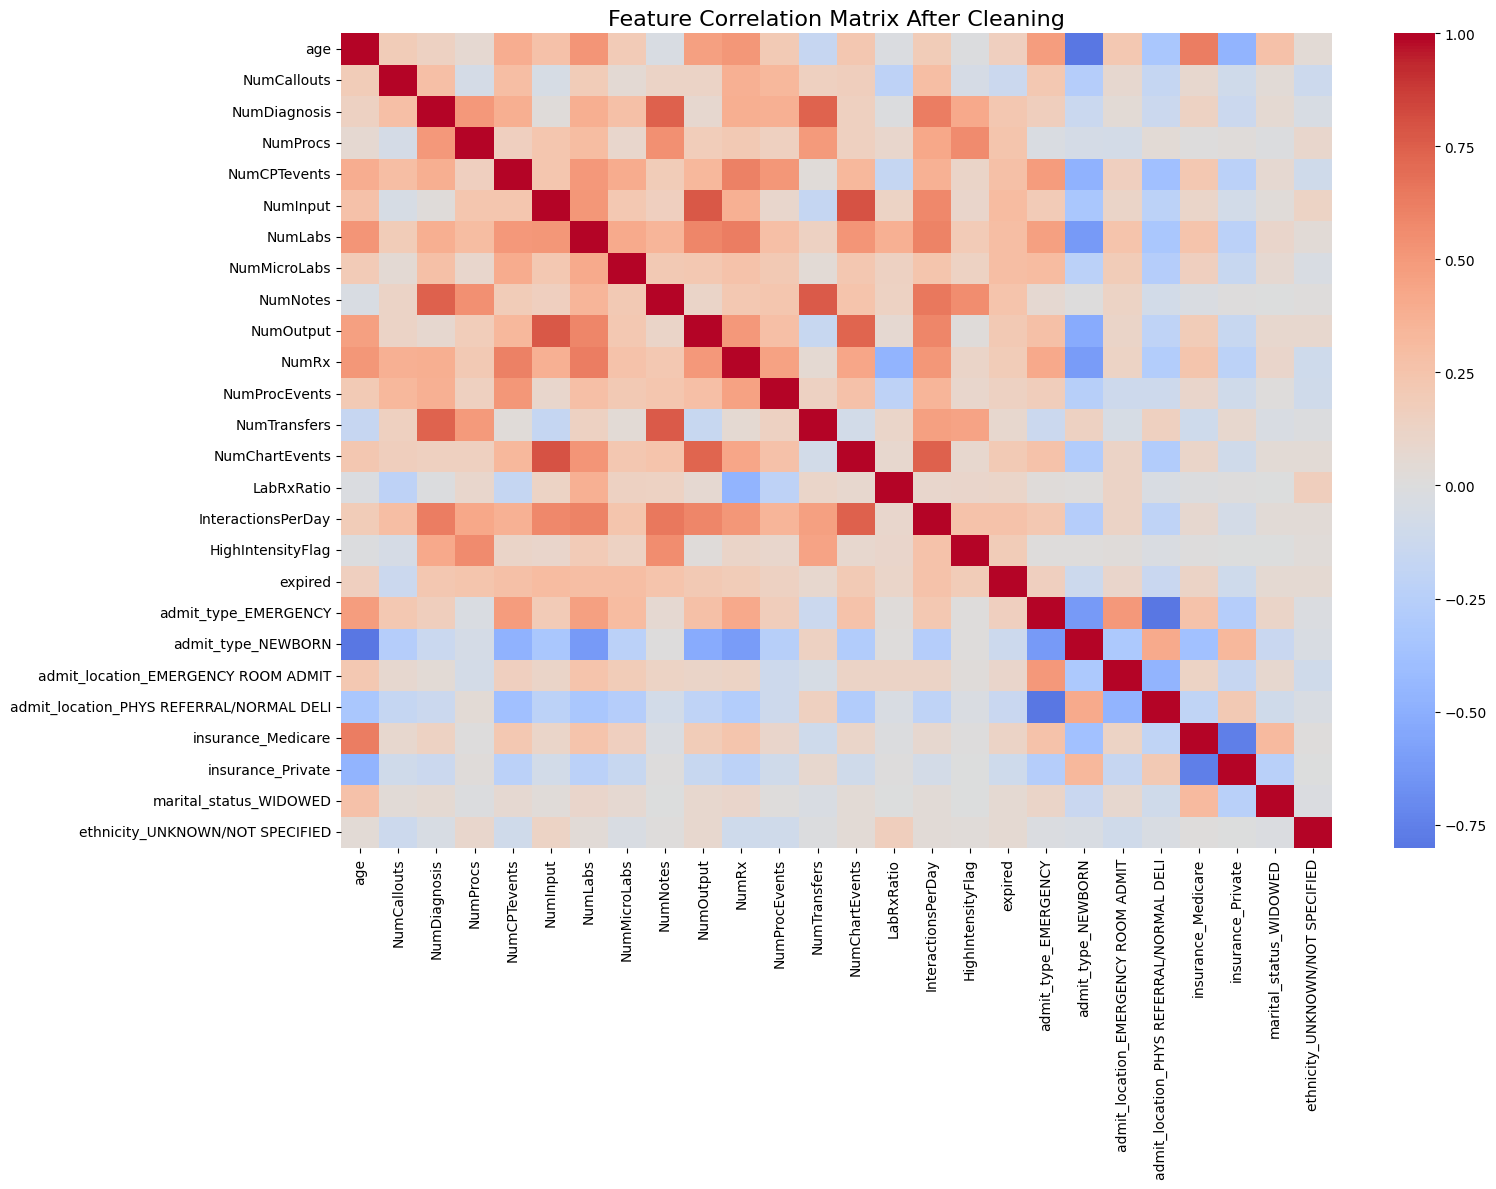


Target variable verification:
Unique values: [0]
Class distribution:
expired
0    58976
Name: count, dtype: int64
Class ratio: 0.0000

Applying SMOTE to balance training data...
Pre-SMOTE class counts: [47180]


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Ensure target is binary
df['expired'] = df['ExpiredHospital'].astype(int)
print(f"Initial target distribution:\n{df['expired'].value_counts()}")
print(f"Class ratio: {df['expired'].mean():.4f}")

# --------------------------
# 2. Initial Data Cleaning
# --------------------------
print("\nPerforming initial data cleaning...")

# Drop columns with >30% missing values
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
print(f"Dropping columns with >30% missing values: {columns_to_drop}")
df.drop(columns=columns_to_drop, inplace=True)

# Domain-based removal
domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Dropping domain-irrelevant features: {domain_drop}")
df.drop(columns=domain_drop, inplace=True, errors='ignore')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

print("\nMissing value treatment:")
print(f"Numerical columns: Imputing with median")
print(f"Categorical columns: Imputing with mode")

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# 3. Feature Elimination Criteria & Visualization
# --------------------------
print("\nApplying feature elimination criteria:")
print("1. Low variance (<0.01)")
print("2. High correlation with other features (>0.9)")
print("3. Low correlation with target (<0.05 absolute correlation)")

# Visualize target correlation before encoding
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --------------------------
# 4. Correlation & Heatmap Analysis
# --------------------------
print("\nCalculating correlations and generating heatmap...")
plt.figure(figsize=(20, 16))
corr_matrix = df.corr()

# Feature elimination based on correlation
# 1. Low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]
print(f"\nLow variance features to drop: {low_variance_cols.tolist()}")

# 2. High correlation
corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"Highly correlated features to drop: {high_corr_cols}")

# 3. Low target correlation
target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()
print(f"Features with low target correlation: {low_target_corr_cols}")

# Combine all elimination criteria
all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
# Don't drop the target variable
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')
    
print(f"\nTotal features to remove: {len(all_to_drop)}")
print(all_to_drop)

# Visualize target correlation after encoding
plt.figure(figsize=(14, 8))
corr_with_target = corr_matrix['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality After Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('post_encoding_correlation.png', dpi=300)
plt.show()

# Create cleaned dataset
df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape before cleaning: {df.shape}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# --------------------------
# 5. Feature Transformation & Visualization
# --------------------------
print("\nPerforming feature transformation...")

# Log transform skewed features
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
print(f"Skewed features to transform: {skewed_cols.tolist()}")

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

# Feature Distribution Visualization
plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# Final correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Feature Correlation Matrix After Cleaning', fontsize=16)
plt.tight_layout()
plt.savefig('final_correlation_heatmap.png', dpi=300)
plt.show()

# --------------------------
# 6. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired'].astype(int)  # Ensure target is integer type

# Verify target is binary
print("\nTarget variable verification:")
print(f"Unique values: {np.unique(y)}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")
print(f"Class ratio: {y.mean():.4f}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE only to training data
print("\nApplying SMOTE to balance training data...")
print(f"Pre-SMOTE class counts: {np.bincount(y_train)}")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Post-SMOTE class counts: {np.bincount(y_train_res)}")

# --------------------------
# 7. Model Selection & Stability Check
# --------------------------
print("\nTraining and evaluating models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Enhanced stability check with StratifiedShuffleSplit
def check_stability(model, X, y, n_runs=5):
    """Check model stability across different stratified splits"""
    accuracies = []
    auc_scores = []
    seeds_used = []
    seeds = range(42, 42 + n_runs)  # Fixed seed sequence
    
    for seed in seeds:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
        for train_idx, test_idx in sss.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Verify class distribution
            train_classes = np.unique(y_train)
            if len(train_classes) < 2:
                print(f"Skipping seed {seed}: Only {train_classes} in training data")
                continue
                
            # Apply SMOTE to training split
            sm = SMOTE(random_state=seed)
            X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
            
            # Train and evaluate
            model.fit(X_train_res, y_train_res)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
                auc_score = roc_auc_score(y_test, y_proba)
            else:
                y_pred = model.predict(X_test)
                auc_score = roc_auc_score(y_test, y_pred)
                
            acc = accuracy_score(y_test, model.predict(X_test))
            
            accuracies.append(acc)
            auc_scores.append(auc_score)
            seeds_used.append(seed)
            print(f"Seed {seed}: Classes {np.bincount(y_train_res)} | Acc={acc:.4f}, AUC={auc_score:.4f}")
    
    if len(accuracies) == 0:
        return 0, 0, 0, 0
    
    return np.mean(accuracies), np.std(accuracies), np.mean(auc_scores), np.std(auc_scores)

# Evaluate models
results = []
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    mean_acc, std_acc, mean_auc, std_auc = check_stability(model, X_scaled, y)
    
    # Train final model on main split
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    # Get AUC score
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = roc_auc_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc_score,
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc,
        "Mean AUC": mean_auc,
        "Std AUC": std_auc
    })
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {auc_score:.4f}")

# Results comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC']])

# --------------------------
# 8. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print("\nTuning Random Forest...")
rf_tuner = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
rf_tuner.fit(X_train_res, y_train_res)
best_rf = rf_tuner.best_estimator_
print(f"Best Random Forest params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

# Tune Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

print("\nTuning Gradient Boosting...")
gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
gb_tuner.fit(X_train_res, y_train_res)
best_gb = gb_tuner.best_estimator_
print(f"Best Gradient Boosting params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

# Tune Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("\nTuning Logistic Regression...")
lr_tuner = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
lr_tuner.fit(X_train_res, y_train_res)
best_lr = lr_tuner.best_estimator_
print(f"Best Logistic Regression params: {lr_tuner.best_params_}")
print(f"Best AUC: {lr_tuner.best_score_:.4f}")

# --------------------------
# 9. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for name, model in final_models.items():
    model.fit(X_train_res, y_train_res)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"\n{name} Final Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# --------------------------
# 10. Feature Importance Analysis
# --------------------------
print("\nGenerating feature importance plots...")

# Random Forest feature importance
if hasattr(best_rf, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    rf_importances = best_rf.feature_importances_
    sorted_idx = np.argsort(rf_importances)[-20:]
    sns.barplot(x=rf_importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')
    plt.title('Top 20 Features - Random Forest Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png', dpi=300)
    plt.show()

# Gradient Boosting feature importance
if hasattr(best_gb, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    gb_importances = best_gb.feature_importances_
    sorted_idx = np.argsort(gb_importances)[-20:]
    sns.barplot(x=gb_importances[sorted_idx], y=X.columns[sorted_idx], palette='mako')
    plt.title('Top 20 Features - Gradient Boosting Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('gb_feature_importance.png', dpi=300)
    plt.show()

# Logistic Regression coefficients
if hasattr(best_lr, 'coef_'):
    plt.figure(figsize=(12, 8))
    coefs = pd.Series(best_lr.coef_[0], index=X.columns).abs().sort_values()[-20:]
    sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
    plt.title('Top 20 Features - Logistic Regression Coefficients', fontsize=14)
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.savefig('logreg_feature_importance.png', dpi=300)
    plt.show()

print("\nAnalysis complete! All visualizations saved to disk.")

Loading data and initial preprocessing...
Initial target distribution:
expired
0    53122
1     5854
Name: count, dtype: int64
Class ratio: 0.0993

Performing initial data cleaning...
Dropping columns with >30% missing values: []
Dropping domain-irrelevant features: ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']

Missing value treatment:
Numerical columns: Imputing with median
Categorical columns: Imputing with mode

Applying feature elimination criteria:
1. Low variance (<0.01)
2. High correlation with other features (>0.9)
3. Low correlation with target (<0.05 absolute correlation)


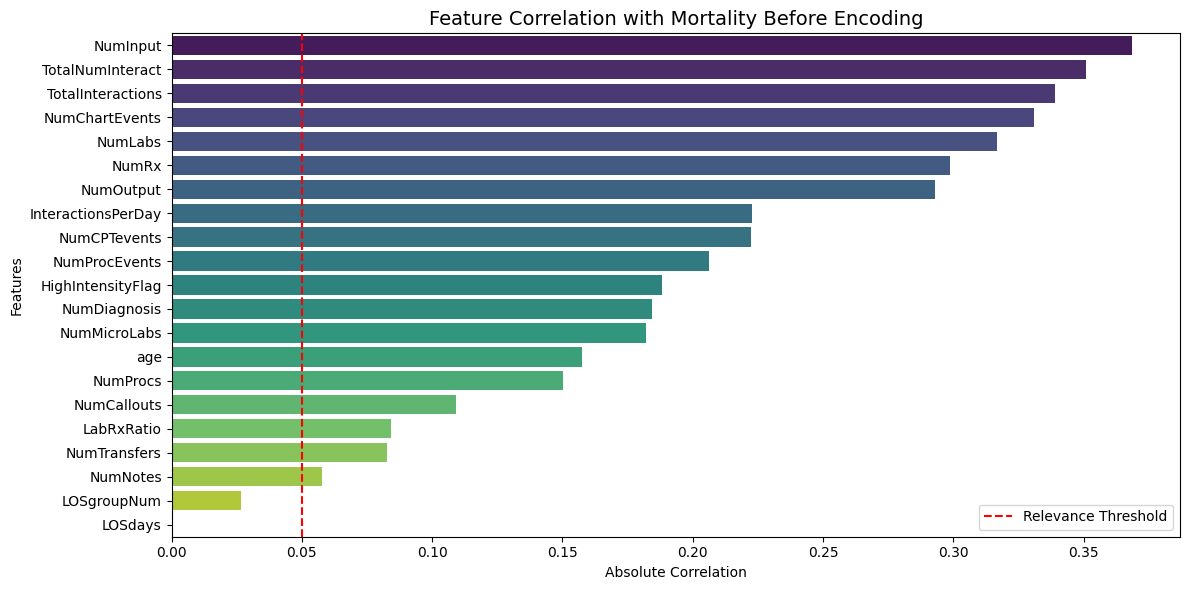


Encoding categorical variables...

Calculating correlations and generating heatmap...

Low variance features to drop: ['admit_location_HMO REFERRAL/SICK', 'admit_location_TRANSFER FROM OTHER HEALT', 'admit_location_TRANSFER FROM SKILLED NUR', 'admit_location_TRSF WITHIN THIS FACILITY', 'religion_BAPTIST', 'religion_BUDDHIST', 'religion_CHRISTIAN SCIENTIST', 'religion_GREEK ORTHODOX', 'religion_HEBREW', 'religion_HINDU', "religion_JEHOVAH'S WITNESS", 'religion_LUTHERAN', 'religion_METHODIST', 'religion_MUSLIM', 'religion_ROMANIAN EAST. ORTH', 'religion_UNITARIAN-UNIVERSALIST', 'marital_status_LIFE PARTNER', 'marital_status_SEPARATED', 'marital_status_UNKNOWN (DEFAULT)', 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE', 'ethnicity_ASIAN - ASIAN INDIAN', 'ethnicity_ASIAN - CAMBODIAN', 'ethnicity_ASIAN - CHINESE', 'ethnicity_ASIAN - FILIPINO', 'ethnicity_ASIAN - JAPANESE', 'ethnicity_ASIAN - KOREAN', 'ethnicity_ASIAN - OTHER', 'ethnicity_ASIAN - THAI', 'ethnicity_ASIAN

<Figure size 2000x1600 with 0 Axes>

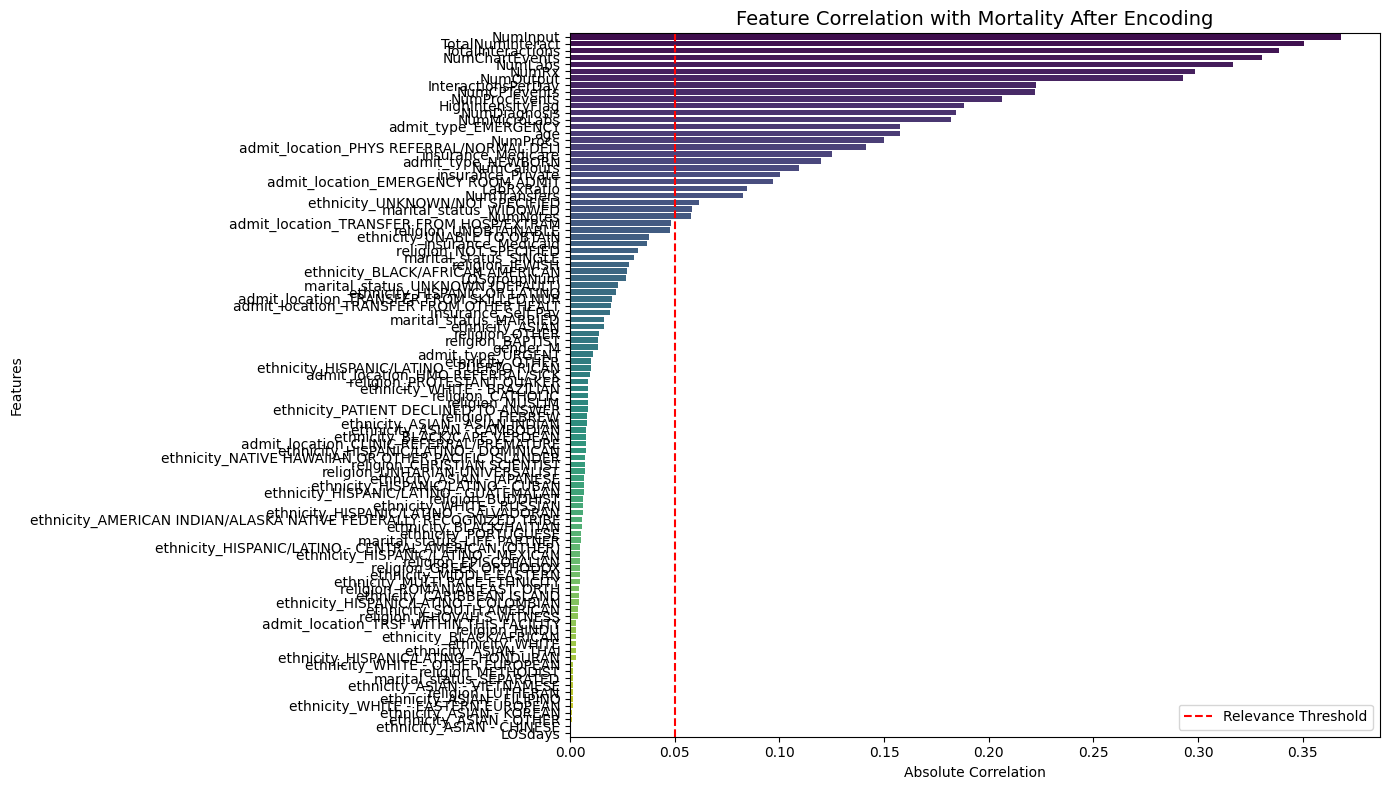


Dataset shape before cleaning: (58976, 103)
Dataset shape after cleaning: (58976, 26)

Performing feature transformation...
Skewed features to transform: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'LabRxRatio', 'InteractionsPerDay', 'HighIntensityFlag', 'expired']


<Figure size 1800x1400 with 0 Axes>

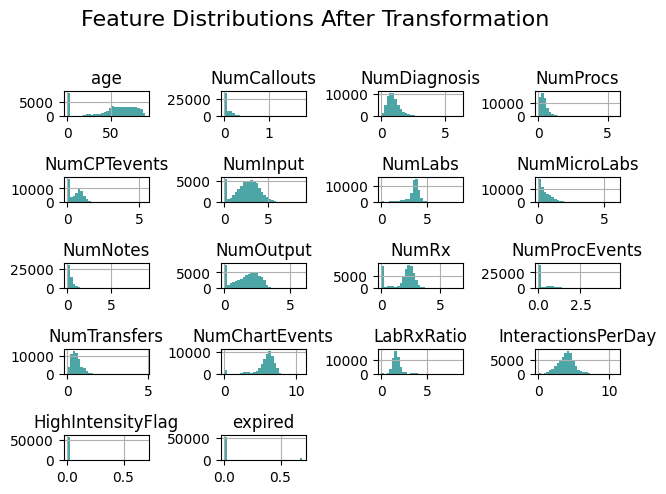

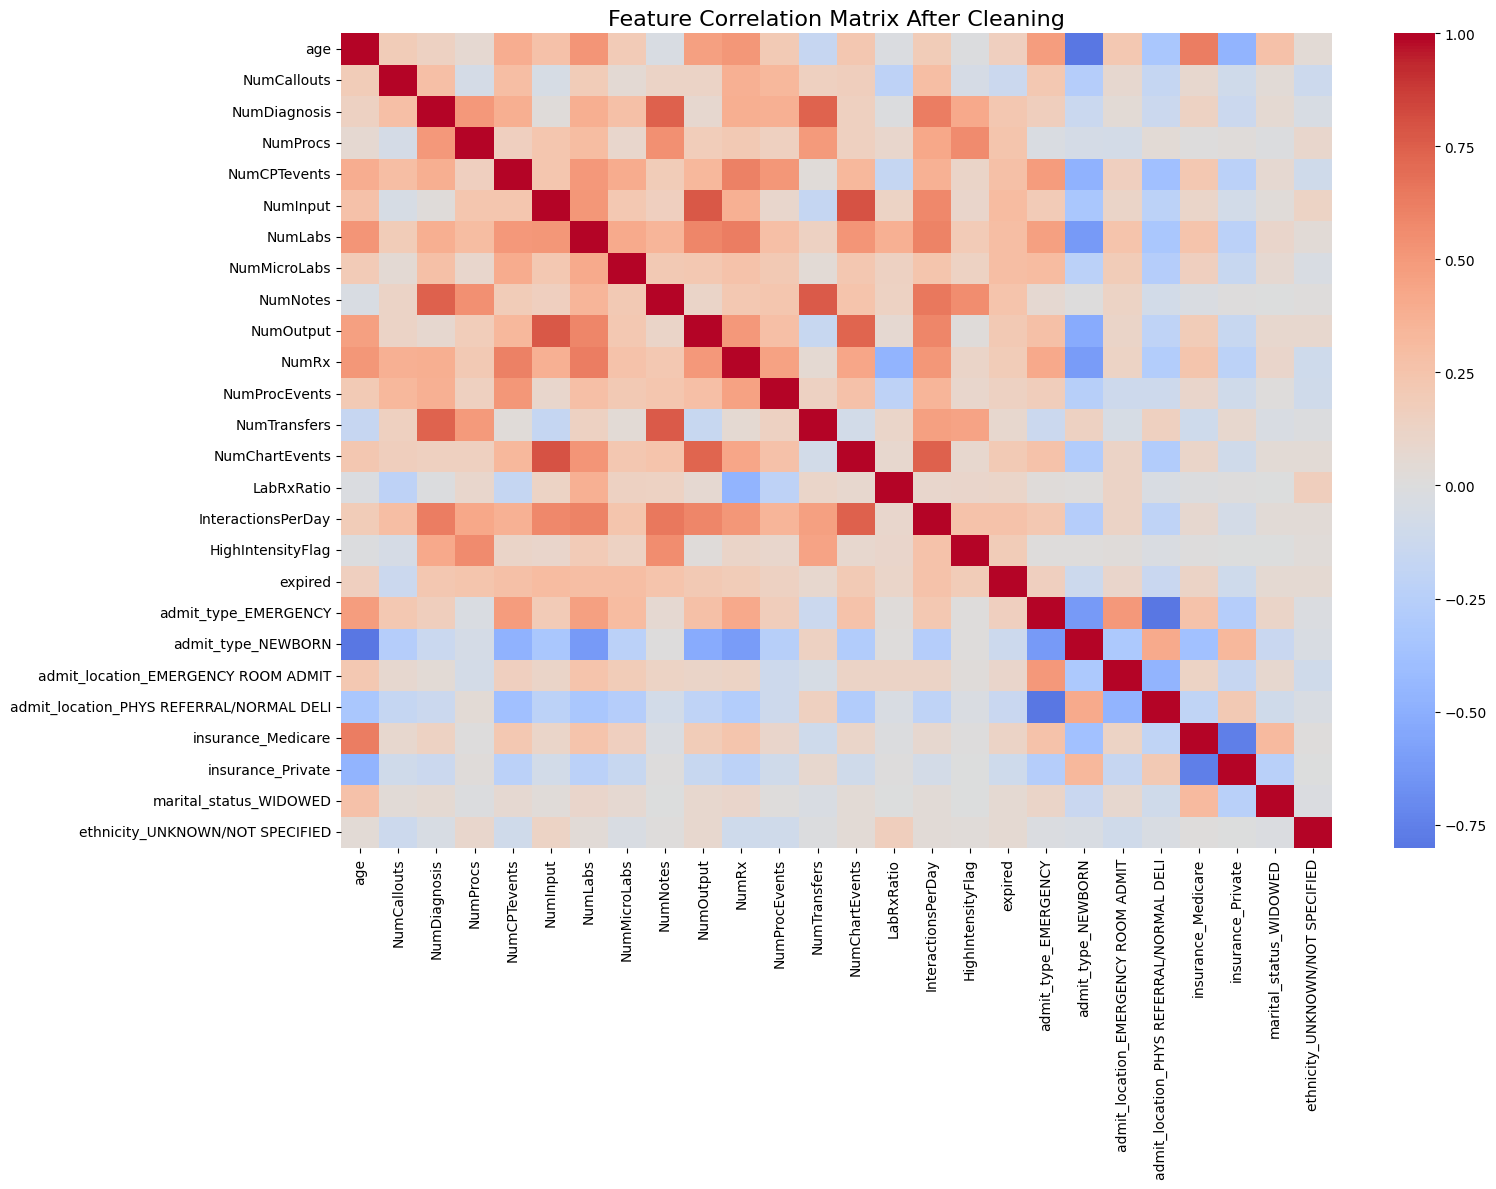


Target variable verification:
Unique values: [0]
Class distribution:
expired
0    58976
Name: count, dtype: int64
Class ratio: 0.0000

Applying SMOTE to balance training data...
Pre-SMOTE class counts: [47180]


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Ensure target is binary
df['expired'] = df['ExpiredHospital'].astype(int)
print(f"Initial target distribution:\n{df['expired'].value_counts()}")
print(f"Class ratio: {df['expired'].mean():.4f}")

# --------------------------
# 2. Initial Data Cleaning
# --------------------------
print("\nPerforming initial data cleaning...")

# Drop columns with >30% missing values
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
print(f"Dropping columns with >30% missing values: {columns_to_drop}")
df.drop(columns=columns_to_drop, inplace=True)

# Domain-based removal
domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Dropping domain-irrelevant features: {domain_drop}")
df.drop(columns=domain_drop, inplace=True, errors='ignore')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

print("\nMissing value treatment:")
print(f"Numerical columns: Imputing with median")
print(f"Categorical columns: Imputing with mode")

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# 3. Feature Elimination Criteria & Visualization
# --------------------------
print("\nApplying feature elimination criteria:")
print("1. Low variance (<0.01)")
print("2. High correlation with other features (>0.9)")
print("3. Low correlation with target (<0.05 absolute correlation)")

# Visualize target correlation before encoding
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# --------------------------
# 4. Correlation & Heatmap Analysis
# --------------------------
print("\nCalculating correlations and generating heatmap...")
plt.figure(figsize=(20, 16))
corr_matrix = df.corr()

# Feature elimination based on correlation
# 1. Low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]
print(f"\nLow variance features to drop: {low_variance_cols.tolist()}")

# 2. High correlation
corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]
print(f"Highly correlated features to drop: {high_corr_cols}")

# 3. Low target correlation
target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()
print(f"Features with low target correlation: {low_target_corr_cols}")

# Combine all elimination criteria
all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
# Don't drop the target variable
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')
    
print(f"\nTotal features to remove: {len(all_to_drop)}")
print(all_to_drop)

# Visualize target correlation after encoding
plt.figure(figsize=(14, 8))
corr_with_target = corr_matrix['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality After Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('post_encoding_correlation.png', dpi=300)
plt.show()

# Create cleaned dataset
df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape before cleaning: {df.shape}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# --------------------------
# 5. Feature Transformation & Visualization
# --------------------------
print("\nPerforming feature transformation...")

# Log transform skewed features
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
print(f"Skewed features to transform: {skewed_cols.tolist()}")

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

# Feature Distribution Visualization
plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# Final correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df_clean.corr(), cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Feature Correlation Matrix After Cleaning', fontsize=16)
plt.tight_layout()
plt.savefig('final_correlation_heatmap.png', dpi=300)
plt.show()

# --------------------------
# 6. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired'].astype(int)  # Ensure target is integer type

# Verify target is binary
print("\nTarget variable verification:")
print(f"Unique values: {np.unique(y)}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")
print(f"Class ratio: {y.mean():.4f}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE only to training data
print("\nApplying SMOTE to balance training data...")
print(f"Pre-SMOTE class counts: {np.bincount(y_train)}")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Post-SMOTE class counts: {np.bincount(y_train_res)}")

# --------------------------
# 7. Model Selection & Stability Check
# --------------------------
print("\nTraining and evaluating models...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Enhanced stability check with StratifiedShuffleSplit
def check_stability(model, X, y, n_runs=5):
    """Check model stability across different stratified splits"""
    accuracies = []
    auc_scores = []
    seeds_used = []
    seeds = range(42, 42 + n_runs)  # Fixed seed sequence
    
    for seed in seeds:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
        for train_idx, test_idx in sss.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Verify class distribution
            train_classes = np.unique(y_train)
            if len(train_classes) < 2:
                print(f"Skipping seed {seed}: Only {train_classes} in training data")
                continue
                
            # Apply SMOTE to training split
            sm = SMOTE(random_state=seed)
            X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
            
            # Train and evaluate
            model.fit(X_train_res, y_train_res)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
                auc_score = roc_auc_score(y_test, y_proba)
            else:
                y_pred = model.predict(X_test)
                auc_score = roc_auc_score(y_test, y_pred)
                
            acc = accuracy_score(y_test, model.predict(X_test))
            
            accuracies.append(acc)
            auc_scores.append(auc_score)
            seeds_used.append(seed)
            print(f"Seed {seed}: Classes {np.bincount(y_train_res)} | Acc={acc:.4f}, AUC={auc_score:.4f}")
    
    if len(accuracies) == 0:
        return 0, 0, 0, 0
    
    return np.mean(accuracies), np.std(accuracies), np.mean(auc_scores), np.std(auc_scores)

# Evaluate models
results = []
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    mean_acc, std_acc, mean_auc, std_auc = check_stability(model, X_scaled, y)
    
    # Train final model on main split
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    
    # Get AUC score
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = roc_auc_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc_score,
        "Mean Accuracy": mean_acc,
        "Std Accuracy": std_acc,
        "Mean AUC": mean_auc,
        "Std AUC": std_auc
    })
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    print(f"AUC: {auc_score:.4f}")

# Results comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df[['Model', 'Accuracy', 'AUC', 'Mean Accuracy', 'Std Accuracy', 'Mean AUC', 'Std AUC']])

# --------------------------
# 8. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print("\nTuning Random Forest...")
rf_tuner = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
rf_tuner.fit(X_train_res, y_train_res)
best_rf = rf_tuner.best_estimator_
print(f"Best Random Forest params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

# Tune Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

print("\nTuning Gradient Boosting...")
gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
gb_tuner.fit(X_train_res, y_train_res)
best_gb = gb_tuner.best_estimator_
print(f"Best Gradient Boosting params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

# Tune Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("\nTuning Logistic Regression...")
lr_tuner = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
lr_tuner.fit(X_train_res, y_train_res)
best_lr = lr_tuner.best_estimator_
print(f"Best Logistic Regression params: {lr_tuner.best_params_}")
print(f"Best AUC: {lr_tuner.best_score_:.4f}")

# --------------------------
# 9. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

for name, model in final_models.items():
    model.fit(X_train_res, y_train_res)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"\n{name} Final Evaluation:")
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
    print(classification_report(y_test, model.predict(X_test)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# --------------------------
# 10. Feature Importance Analysis
# --------------------------
print("\nGenerating feature importance plots...")

# Random Forest feature importance
if hasattr(best_rf, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    rf_importances = best_rf.feature_importances_
    sorted_idx = np.argsort(rf_importances)[-20:]
    sns.barplot(x=rf_importances[sorted_idx], y=X.columns[sorted_idx], palette='viridis')
    plt.title('Top 20 Features - Random Forest Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png', dpi=300)
    plt.show()

# Gradient Boosting feature importance
if hasattr(best_gb, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    gb_importances = best_gb.feature_importances_
    sorted_idx = np.argsort(gb_importances)[-20:]
    sns.barplot(x=gb_importances[sorted_idx], y=X.columns[sorted_idx], palette='mako')
    plt.title('Top 20 Features - Gradient Boosting Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('gb_feature_importance.png', dpi=300)
    plt.show()

# Logistic Regression coefficients
if hasattr(best_lr, 'coef_'):
    plt.figure(figsize=(12, 8))
    coefs = pd.Series(best_lr.coef_[0], index=X.columns).abs().sort_values()[-20:]
    sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
    plt.title('Top 20 Features - Logistic Regression Coefficients', fontsize=14)
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.savefig('logreg_feature_importance.png', dpi=300)
    plt.show()

print("\nAnalysis complete! All visualizations saved to disk.")

Loading data and initial preprocessing...
Initial target distribution:
expired
0    53122
1     5854
Name: count, dtype: int64
Class ratio: 0.0993

Performing initial data cleaning...
Dropping columns with >30% missing values: []
Dropping domain-irrelevant features: ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']

Missing value treatment:
Numerical columns: Imputing with median
Categorical columns: Imputing with mode

Applying feature elimination criteria...


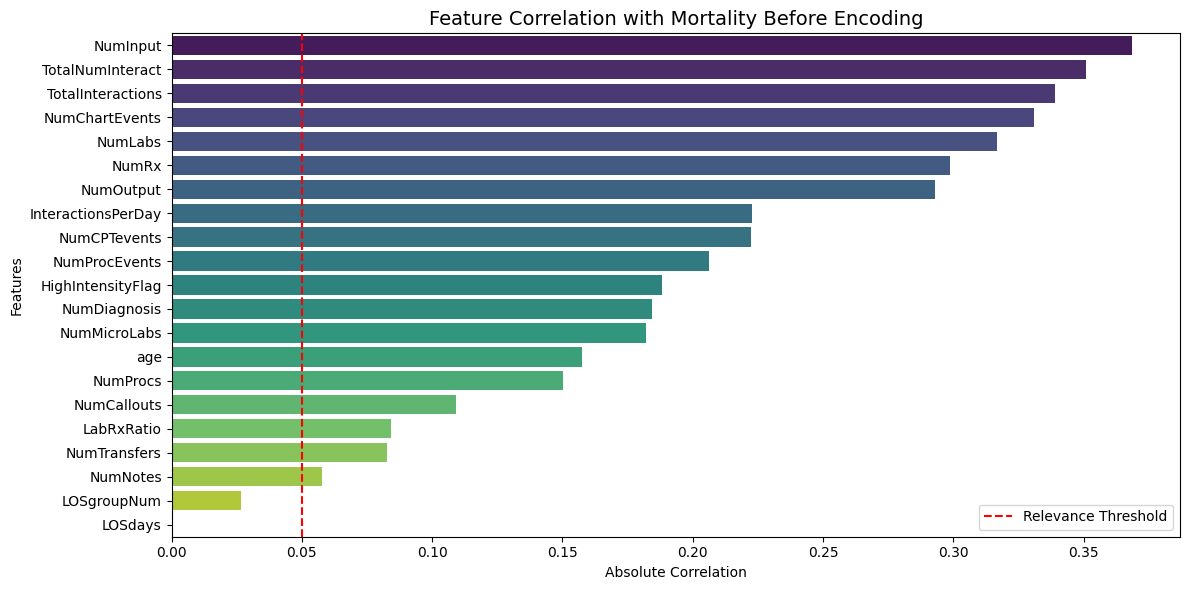


Encoding categorical variables...

Total features to remove: 77

Dataset shape before cleaning: (58976, 103)
Dataset shape after cleaning: (58976, 26)

Performing feature transformation...
Skewed features to transform: ['NumCallouts', 'NumDiagnosis', 'NumProcs', 'NumCPTevents', 'NumInput', 'NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 'NumRx', 'NumProcEvents', 'NumTransfers', 'NumChartEvents', 'LabRxRatio', 'InteractionsPerDay', 'HighIntensityFlag', 'expired']


<Figure size 1800x1400 with 0 Axes>

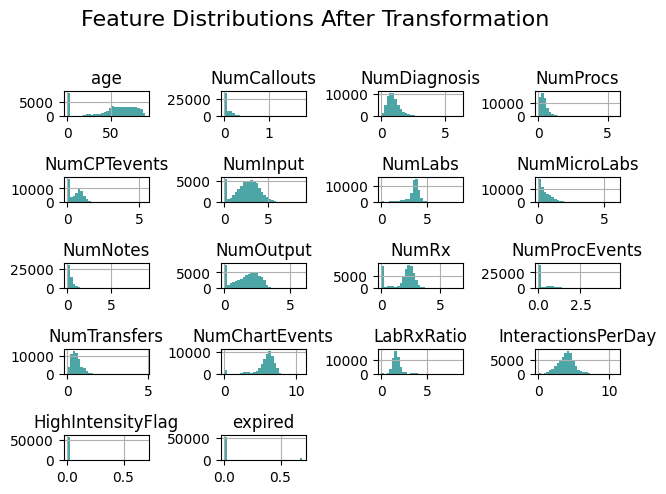


Target variable verification:
Unique values: [0]
Class distribution:
expired
0    58976
Name: count, dtype: int64
Class ratio: 0.0000

Applying imbalance strategy: smoteenn
Original class distribution: Counter({0: 47180})


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score, 
                             precision_recall_curve, auc, f1_score)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# --------------------------
# 1. Data Loading & Initial Prep
# --------------------------
print("Loading data and initial preprocessing...")
df = pd.read_csv('mimic3c.csv')

# Feature Engineering
df['TotalInteractions'] = (
    df['NumLabs'] + df['NumMicroLabs'] + df['NumRx'] + 
    df['NumNotes'] + df['NumProcs'] + df['NumChartEvents']
)
df['LabRxRatio'] = df['NumLabs'] / (df['NumRx'] + 1)
df['InteractionsPerDay'] = df['TotalInteractions'] / (df['LOSdays'] + 1)
df['HighIntensityFlag'] = ((df['NumNotes'] > 10) & (df['NumProcs'] > 5)).astype(int)

# Ensure target is binary
df['expired'] = df['ExpiredHospital'].astype(int)
print(f"Initial target distribution:\n{df['expired'].value_counts()}")
print(f"Class ratio: {df['expired'].mean():.4f}")

# --------------------------
# 2. Initial Data Cleaning
# --------------------------
print("\nPerforming initial data cleaning...")

# Drop columns with >30% missing values
missing_percent = df.isnull().mean()
columns_to_drop = missing_percent[missing_percent > 0.3].index.tolist()
print(f"Dropping columns with >30% missing values: {columns_to_drop}")
df.drop(columns=columns_to_drop, inplace=True)

# Domain-based removal
domain_drop = ['hadm_id', 'AdmitDiagnosis', 'AdmitProcedure', 'ExpiredHospital']
print(f"Dropping domain-irrelevant features: {domain_drop}")
df.drop(columns=domain_drop, inplace=True, errors='ignore')

# Handle missing values
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

print("\nMissing value treatment:")
print(f"Numerical columns: Imputing with median")
print(f"Categorical columns: Imputing with mode")

# Impute numerical columns
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --------------------------
# 3. Feature Elimination & Encoding
# --------------------------
print("\nApplying feature elimination criteria...")

# Visualize target correlation before encoding
plt.figure(figsize=(12, 6))
corr_with_target = df[num_cols].corr()['expired'].drop('expired').abs().sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.axvline(x=0.05, color='r', linestyle='--', label='Relevance Threshold')
plt.title('Feature Correlation with Mortality Before Encoding', fontsize=14)
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')
plt.legend()
plt.tight_layout()
plt.savefig('pre_encoding_correlation.png', dpi=300)
plt.show()

# Encode categorical variables
print("\nEncoding categorical variables...")
categorical_cols = ['gender', 'admit_type', 'admit_location', 'insurance', 'religion', 
                    'marital_status', 'ethnicity']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature elimination based on correlation
corr_matrix = df.corr()

# 1. Low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df)
low_variance_cols = df.columns[~selector.get_support()]

# 2. High correlation
corr_threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
high_corr_cols = [column for column in upper.columns if any(upper[column] > corr_threshold)]

# 3. Low target correlation
target_corr = corr_matrix['expired'].abs()
low_target_corr_cols = target_corr[target_corr < 0.05].index.tolist()

# Combine all elimination criteria
all_to_drop = list(set(low_variance_cols.tolist() + high_corr_cols + low_target_corr_cols))
if 'expired' in all_to_drop:
    all_to_drop.remove('expired')
    
print(f"\nTotal features to remove: {len(all_to_drop)}")

# Create cleaned dataset
df_clean = df.drop(columns=all_to_drop, errors='ignore')
print(f"\nDataset shape before cleaning: {df.shape}")
print(f"Dataset shape after cleaning: {df_clean.shape}")

# --------------------------
# 4. Feature Transformation
# --------------------------
print("\nPerforming feature transformation...")

# Log transform skewed features
skew_threshold = 1.0
numeric_cols = df_clean.select_dtypes(include=np.number).columns
skewness = df_clean[numeric_cols].apply(lambda x: stats.skew(x.dropna()))
skewed_cols = skewness[abs(skewness) > skew_threshold].index
print(f"Skewed features to transform: {skewed_cols.tolist()}")

df_clean[skewed_cols] = np.log1p(df_clean[skewed_cols])

# Feature Distribution Visualization
plt.figure(figsize=(18, 14))
df_clean[numeric_cols].hist(bins=30, layout=(5, 4), color='teal', alpha=0.7)
plt.suptitle('Feature Distributions After Transformation', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# --------------------------
# 5. Model Preparation
# --------------------------
X = df_clean.drop(columns=['expired'])
y = df_clean['expired'].astype(int)

print("\nTarget variable verification:")
print(f"Unique values: {np.unique(y)}")
print(f"Class distribution:\n{pd.Series(y).value_counts()}")
print(f"Class ratio: {y.mean():.4f}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------
# 6. Imbalance Handling Strategy
# --------------------------
# Choose imbalance handling strategy
IMBALANCE_STRATEGY = 'smoteenn'  # Options: 'class_weight', 'undersample', 'smoteenn'

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nApplying imbalance strategy: {IMBALANCE_STRATEGY}")
print(f"Original class distribution: {Counter(y_train)}")

# Apply selected strategy
if IMBALANCE_STRATEGY == 'smoteenn':
    sampler = SMOTEENN(random_state=42)
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)
    print(f"Resampled class distribution: {Counter(y_train_res)}")
elif IMBALANCE_STRATEGY == 'undersample':
    rus = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    print(f"Resampled class distribution: {Counter(y_train_res)}")
elif IMBALANCE_STRATEGY == 'class_weight':
    print("Using class_weight='balanced' in models")
    X_train_res, y_train_res = X_train, y_train
else:
    raise ValueError("Invalid imbalance strategy chosen.")

# --------------------------
# 7. Model Definition
# --------------------------
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, 
        random_state=42,
        class_weight='balanced' if IMBALANCE_STRATEGY == 'class_weight' else None
    ),
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight='balanced' if IMBALANCE_STRATEGY == 'class_weight' else None
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# --------------------------
# 8. Stability Check
# --------------------------
def stability_check(model, X, y, strategy, n_runs=5):
    """Enhanced stability check with imbalance handling"""
    accuracies = []
    f1_scores = []
    auc_scores = []
    seeds = range(42, 42 + n_runs)
    
    for seed in seeds:
        # Create stratified split
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
        for train_idx, test_idx in sss.split(X, y):
            X_train_fold, X_test_fold = X[train_idx], X[test_idx]
            y_train_fold, y_test_fold = y[train_idx], y[test_idx]
            
            # Apply imbalance strategy
            if strategy == 'smoteenn':
                sampler = SMOTEENN(random_state=seed)
                X_train_res, y_train_res = sampler.fit_resample(X_train_fold, y_train_fold)
            elif strategy == 'undersample':
                rus = RandomUnderSampler(random_state=seed)
                X_train_res, y_train_res = rus.fit_resample(X_train_fold, y_train_fold)
            else:  # class_weight
                X_train_res, y_train_res = X_train_fold, y_train_fold
                
            # Verify both classes present
            if len(np.unique(y_train_res)) < 2:
                print(f"Warning: Only one class in training data (seed {seed})")
                continue
                
            # Train and evaluate
            model.fit(X_train_res, y_train_res)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_fold)[:, 1]
                auc_score = roc_auc_score(y_test_fold, y_proba)
            else:
                y_pred = model.predict(X_test_fold)
                auc_score = roc_auc_score(y_test_fold, y_pred)
                
            y_pred = model.predict(X_test_fold)
            acc = accuracy_score(y_test_fold, y_pred)
            f1 = f1_score(y_test_fold, y_pred)
            
            accuracies.append(acc)
            f1_scores.append(f1)
            auc_scores.append(auc_score)
            
            print(f"Seed {seed}: Acc={acc:.4f}, F1={f1:.4f}, AUC={auc_score:.4f}")
    
    if not accuracies:
        return 0, 0, 0, 0, 0, 0
    
    return (
        np.mean(accuracies), np.std(accuracies),
        np.mean(f1_scores), np.std(f1_scores),
        np.mean(auc_scores), np.std(auc_scores)
    )

# --------------------------
# 9. Model Training & Evaluation
# --------------------------
results = []
print("\nTraining models with stability checks...")

for name, model in models.items():
    print(f"\n--- {name} ---")
    mean_acc, std_acc, mean_f1, std_f1, mean_auc, std_auc = stability_check(
        model, X_scaled, y, IMBALANCE_STRATEGY
    )
    
    # Final training on main split
    model.fit(X_train_res, y_train_res)
    
    # Test set evaluation
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_proba)
    else:
        test_auc = roc_auc_score(y_test, y_pred)
    
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Test Accuracy": test_acc,
        "Test F1": test_f1,
        "Test AUC": test_auc,
        "Stability Acc (Mean)": mean_acc,
        "Stability Acc (Std)": std_acc,
        "Stability F1 (Mean)": mean_f1,
        "Stability F1 (Std)": std_f1,
        "Stability AUC (Mean)": mean_auc,
        "Stability AUC (Std)": std_auc
    })
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Results comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)

# --------------------------
# 10. Hyperparameter Tuning
# --------------------------
print("\nPerforming hyperparameter tuning...")

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

print("\nTuning Random Forest...")
rf_tuner = GridSearchCV(
    RandomForestClassifier(
        random_state=42,
        class_weight='balanced' if IMBALANCE_STRATEGY == 'class_weight' else None
    ),
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
rf_tuner.fit(X_train_res, y_train_res)
best_rf = rf_tuner.best_estimator_
print(f"Best params: {rf_tuner.best_params_}")
print(f"Best AUC: {rf_tuner.best_score_:.4f}")

# Tune Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

print("\nTuning Gradient Boosting...")
gb_tuner = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
gb_tuner.fit(X_train_res, y_train_res)
best_gb = gb_tuner.best_estimator_
print(f"Best params: {gb_tuner.best_params_}")
print(f"Best AUC: {gb_tuner.best_score_:.4f}")

# Tune Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("\nTuning Logistic Regression...")
lr_tuner = GridSearchCV(
    LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced' if IMBALANCE_STRATEGY == 'class_weight' else None
    ),
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)
lr_tuner.fit(X_train_res, y_train_res)
best_lr = lr_tuner.best_estimator_
print(f"Best params: {lr_tuner.best_params_}")
print(f"Best AUC: {lr_tuner.best_score_:.4f}")

# --------------------------
# 11. Final Model Evaluation
# --------------------------
final_models = {
    "Tuned Logistic Regression": best_lr,
    "Tuned Random Forest": best_rf,
    "Tuned Gradient Boosting": best_gb
}

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Random')

# Store results for final comparison
final_results = []

for name, model in final_models.items():
    model.fit(X_train_res, y_train_res)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    
    # Classification metrics
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    final_results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        "Accuracy": report['accuracy'],
        "Precision (Class 1)": report['1']['precision'],
        "Recall (Class 1)": report['1']['recall'],
        "F1 (Class 1)": report['1']['f1-score']
    })
    
    print(f"\n{name} Final Evaluation:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Final Models', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300)
plt.show()

# Final results comparison
final_results_df = pd.DataFrame(final_results)
print("\nFinal Model Comparison:")
print(final_results_df)

# --------------------------
# 12. Feature Importance Analysis
# --------------------------
print("\nGenerating feature importance plots...")

# Get feature names
feature_names = df_clean.drop(columns=['expired']).columns

# Random Forest feature importance
if hasattr(best_rf, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    rf_importances = best_rf.feature_importances_
    sorted_idx = np.argsort(rf_importances)[-20:]
    sns.barplot(x=rf_importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')
    plt.title('Top 20 Features - Random Forest Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('rf_feature_importance.png', dpi=300)
    plt.show()

# Gradient Boosting feature importance
if hasattr(best_gb, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    gb_importances = best_gb.feature_importances_
    sorted_idx = np.argsort(gb_importances)[-20:]
    sns.barplot(x=gb_importances[sorted_idx], y=feature_names[sorted_idx], palette='mako')
    plt.title('Top 20 Features - Gradient Boosting Importance', fontsize=14)
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.savefig('gb_feature_importance.png', dpi=300)
    plt.show()

# Logistic Regression coefficients
if hasattr(best_lr, 'coef_'):
    plt.figure(figsize=(12, 8))
    coefs = pd.Series(best_lr.coef_[0], index=feature_names).abs().sort_values()[-20:]
    sns.barplot(x=coefs.values, y=coefs.index, palette='rocket')
    plt.title('Top 20 Features - Logistic Regression Coefficients', fontsize=14)
    plt.xlabel('Absolute Coefficient Value')
    plt.tight_layout()
    plt.savefig('logreg_feature_importance.png', dpi=300)
    plt.show()

print("\nAnalysis complete! All visualizations saved to disk.")